In [1]:
# %matplotlib notebook

import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.integrate import solve_ivp

# Toy Simulations

In [ ]:
def solve_euler(dif_f, init, trange, step):
    sol = np.zeros((len(init), int((trange[1]-trange[0])//step) + (0 if (trange[1]-trange[0]) % step == 0 else 1)))
    sol[:,0] = init
    step_num = 0
    for k in np.arange(trange[0], trange[1]-step, step):
        sol[:, step_num+1] = sol[:, step_num] + step * dif_f(k, sol[:, step_num])
        step_num += 1
    return sol

def eval_solver(dif_f, sol, init, trange, t_step_range=[-7, 1.5], num_step_sizes=100):
    tsteps = []
    diffs = []
    for tstep in np.logspace(t_step_range[0], t_step_range[1], num_step_sizes):
        num_sol = solve_euler(dif_f, init, trange, tstep)
        print(f"done {tstep}")
        print(f"{num_sol.shape} {np.arange(trange[0], trange[1], tstep).shape}")
        acc_sol = np.array([sol(t) for t in np.arange(trange[0], trange[1], tstep)])
        avg_dif = np.average(np.abs(num_sol[0]-acc_sol)) 
        tsteps.append(tstep)
        diffs.append(avg_dif)
        
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Integration Time Step ∆t (s)")
    plt.ylabel("Average Error ∆x (m)")
    plt.plot(np.array(tsteps), np.array(diffs))

## Mass-Spring System

In [ ]:
%%latex
Differential Equation: $$ \ddot{x}=-\frac{k}{m}x, x(0)=x_0 $$

Analytical Solution: $$ x(t)=x_0 \cos(\omega t) $$ where $\omega=\sqrt{\frac{k}{m}}$

In [ ]:
m = 10 # kg
k = 5 # kg/s^-2

def f(t, y):
    return np.array([y[1], -(k/m)*y[0]])

init = [5, 0]
def sol1(t):
    return 5*np.cos(np.sqrt(k/m)*t)

trange1 = [0, 10*2*np.pi*((m/k)**0.5)]
step1 = 0.001
sol = solve_euler(f, init, trange1, step1)

plt.plot(np.arange(trange1[0], trange1[1], step1), sol[0])
# plt.plot(trange1, sol1(trange1))
plt.xlabel("t (s)")
plt.ylabel("x (m)")
plt.show()

In [ ]:
eval_solver(f, sol1, init, trange=trange1, t_step_range=[-3, 1.5])
plt.show()

## Two Coupled Masses System

In [ ]:
%%latex
Differential Equations:
$$ \ddot{x_1} = -\frac{k_1}{m}x_1+\frac{k_2}{m}\left((x_2-x_1)-d\right), x_1(0)=x_{1,0} $$
$$ \ddot{x_2} = -\frac{k_2}{m}\left((x_2-x_1)-d\right)-\frac{k_1}{m}(x_2-d), x_2(0)=x_{2,0} $$
Analytic Solutions:
$$ x_1(t) = \frac{x_{1,0}+x_{2,0}}{2}\cos(\omega_1 t)+\frac{x_{1,0}-x_{2,0}}{2}\cos(\omega_2 t) $$
$$ x_2(t) = \frac{x_{1,0}+x_{2,0}}{2}\cos(\omega_1 t)-\frac{x_{1,0}-x_{2,0}}{2}\cos(\omega_2 t) $$
where $\omega_1=\sqrt{\frac{k_1}{m}}$ and $\omega_2=\sqrt{\frac{k_1+2k_2}{m}}$. If $x_2(0)=0$, we can write $x_1(t)$ as
$$ x_1(t)=x_{1,0}cos\left(\frac{\omega_1+\omega_2}{2}t\right)cos\left(\frac{\omega_1-\omega_2}{2}t\right)$$


In [ ]:
m = 10
k1 = 5
k2 = 1
d = 0 # doesn't affect much

omega1 = (k1/m) ** 0.5
omega2 = ((k1+2*k2)/m) ** 0.5

def f2(t, y):
    return np.array([
                        y[1],
                        -(k1/m)*y[0]-(k2/m)*(d-(y[2]-y[0])),
                        y[3],
                        (k2/m)*(d-(y[2]-y[0]))-(k1/m)*(y[2]-d)
                    ])

init2 = [2, 0, 0, 0]
def sol2(t):
    return ((init2[0]+init2[2])/2)*np.cos(omega1*t) + ((init2[0]-init2[2])/2)*np.cos(omega2*t)

trange2 = [0, 500]
step2 = 0.0005
num_sol2 = solve_euler(f2, init2, trange2, step2)

plt.plot(np.arange(trange2[0], trange2[1], step2), num_sol2[0])
plt.plot(np.arange(trange2[0], trange2[1], step2), num_sol2[2])
# plt.plot(num_sol2.t, sol2(num_sol2.t))
plt.xlabel("t (s)")
plt.ylabel("x (m)")
plt.show()

In [ ]:
eval_solver(f2, sol2, init2, trange=trange2, t_step_range=[-3, 3], num_step_sizes=50)
plt.show()

## Two Coupled Masses System for Eigenenergies

In [ ]:
# physical constants
m = 10
k = 5
kc = 1

In [ ]:
np.sqrt((k+2*kc)/m)/(2*np.pi)

In [ ]:
# simulation functions 

def acceleration(x):
    return np.array([
        (1/m) * ( -(k+kc)*x[0] + kc*x[1] ),
        (1/m) * ( kc*x[0] - (k+kc)*x[1] ),
    ])

def sim_leapfrog(T, dt, x_0, v_0):
    n_tsteps = int(T / dt)

    x = np.zeros((n_tsteps+1, 2))
    v = np.zeros((n_tsteps+1, 2))
    vhalf = np.zeros((n_tsteps+1, 2))
    a = np.zeros((n_tsteps+1, 2))

    x[0] = x_0
    v[0] = v_0
    a[0] = acceleration(x_0)

    for i in range(n_tsteps):
        vhalf[i] = v[i] + 0.5*dt*a[i]
        x[i+1] = x[i] + dt*vhalf[i]
        a[i+1] = acceleration(x[i+1])
        v[i+1] = vhalf[i] + 0.5*dt*a[i+1]
    
    return x, v

# solve_ivp version
def f(t, y): # y = [x1, x2, v1, v2]
    return np.array([
        y[2],
        y[3],
        (1/m) * ( -(k+kc)*y[0] + kc*y[1] ),
        (1/m) * ( kc*y[0] - (k+kc)*y[1] )
    ])

In [ ]:
# run simulation

T = 1e4
dt = 1e-1

x_0 = np.array([1, -2])
v_0 = np.array([0, 0])
x_sim, v_sim = sim_leapfrog(T, dt, x_0, v_0)

# sol = solve_ivp(f, (0, T), [1, -2, 0, 0], method="DOP853", atol=1e-10, rtol=1e-10)

In [ ]:
# plot trajectories

t_sim = t_sim = np.linspace(0, T, int(T/dt)+1)
plt.plot(t_sim, x_sim[:,0])
plt.plot(t_sim, x_sim[:,1])
# plt.xlim(0, 100)
plt.show()

# plt.plot(sol.t, sol.y[0])
# # plt.plot(sol.t, sol.y[1])
# plt.xlim((0,100))
# plt.show()

In [ ]:
# fourier transform
from scipy.signal import welch, butter, sosfilt

n_tsteps = int(T/dt)

i = 1000
freq, Pxx_spec = welch(x_sim[i:i+10000,0], fs=(1/dt), window="hann", scaling="spectrum", nperseg=n_tsteps)
lin_spec = Pxx_spec ** 0.5
plt.plot(freq, lin_spec)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Linear Spectrum (m)")
plt.xlim(0, 0.5)
plt.show()

In [ ]:
from scipy.signal import argrelmax

maxis = argrelmax(yf1)[0]
for i in maxis:
    print(xf[i])

## Damped Harmonic Oscillator

In [ ]:
# Physical constants
m = 10
k = 10
b = 0.1

# Other constants
omega = np.sqrt(k / m)
gamma = b / (2 * m)

In [ ]:
#  Analytical solution
def underdamped_solution(tinterval, x_0, v_0):
    Omega = np.sqrt(omega**2 - gamma**2)
    A = x_0
    B = (gamma*x_0 + v_0) / Omega
    return A*np.exp(-gamma*tinterval)*np.cos(Omega*tinterval) + B*np.exp(-gamma*tinterval)*np.sin(Omega*tinterval)

def critdamped_solution(tinterval, x_0, v_0):
    A = x_0
    B = gamma*x_0 + v_0
    return (A + B*tinterval) * np.exp(-gamma*tinterval)

def overdamped_solution(tinterval, x_0, v_0):
    Omega = np.sqrt(gamma**2 - omega**2)
    A = (x_0*(gamma+Omega) + v_0) / (2 * Omega)
    B = (x_0*(-gamma+Omega) - v_0) / (2 * Omega)
    return A*np.exp((-gamma+Omega)*tinterval) + B*np.exp((-gamma-Omega)*tinterval)
    
def damped_oscillator_trajectory(tinterval, x_0, v_0):
    if gamma**2 - omega**2 < 0:
        return underdamped_solution(tinterval, x_0, v_0)
    if gamma**2 - omega**2 == 0:
        return critdamped_solution(tinterval, x_0, v_0)
    else:
        return overdamped_solution(tinterval, x_0, v_0)

In [ ]:
# Simulation and acceleration calculation

def acceleration(x, v):
    return -(k/m)*x - (b/m)*v

def leapfrog_sim(T, dt, x_0, v_0):
    n_tsteps = int(T / dt)

    x = np.zeros((n_tsteps+1))
    v = np.zeros((n_tsteps+1))
    vhalf = np.zeros((n_tsteps+1))
    a = np.zeros((n_tsteps+1))

    x[0] = x_0
    v[0] = v_0
    a[0] = acceleration(x_0, v_0)

    for i in range(n_tsteps):
        vhalf[i] = v[i] + 0.5*dt*a[i]
        x[i+1] = x[i] + dt*vhalf[i]
        a[i+1] = acceleration(x[i+1], v[i])
        v[i+1] = vhalf[i] + 0.5*dt*a[i+1]
    
    return x, v

# Euler-Richardson Simulation
def er_sim(n_tsteps, dt, etol, x_0, v_0):
    
    x = np.zeros((n_tsteps + 1))
    v = np.zeros((n_tsteps+1))
    a = np.zeros((n_tsteps+1))
    t = np.zeros((n_tsteps+1))
    err = np.zeros((n_tsteps + 1))

    x[0] = x_0
    v[0] = v_0
    a[0] = acceleration(x_0, v_0)

    for i in range(n_tsteps):
        err[i+1] = etol + 1
        while err[i+1] >= etol:
            xhalf = x[i] + v[i]*(dt/2)
            vhalf = v[i] + a[i]*(dt/2)
            ahalf = acceleration(xhalf, vhalf)
            xerr = np.abs( ( (v[i] - vhalf)*dt ) / 2) # 1 is the order of magnitude of x
            verr = np.abs( ( (a[i] - ahalf)*dt ) / 2) # 1 is the order of magnitude of v
            err[i+1] = max(xerr, verr)
            if err[i+1] < etol:
                x[i+1] = x[i] + vhalf*dt
                v[i+1] = v[i] + ahalf*dt
                a[i+1] = acceleration(x[i+1], v[i+1])
                t[i+1] = t[i] + dt
            else:
                dt = 0.9 * ( (etol / err[i+1])**2 ) * dt

    return x, v, t, err

# 3 for solve_ivp
def f(t, y):
    return np.array([ y[1], -(k/m)*y[0] - (b/m)*y[1] ])

In [ ]:
# Run Simulation

T = 1000
dt = 0.1

x_0 = 1
v_0 = 0

# x_l_sim, v_l_sim = leapfrog_sim(T, dt, x_0, v_0)
# x_l_sim = np.array(x_l_sim); v_er_sim = np.array(v_l_sim)
x_er_sim, v_er_sim, t_er_sim, er_err = er_sim(int(T/dt), dt, 1e-2, x_0, v_0)

# x_er_sim = np.array(x_er_sim)
# v_er_sim = np.array(v_er_sim)
# t_er_sim = np.array(t_er_sim)
# er_err = np.array(er_err)

sol = solve_ivp(f, (0, T), [x_0, v_0], method="DOP853", atol=1e-10, rtol=1e-10)

In [ ]:
# Plot trajectory

# # tinterval = np.arange(0, T+dt, dt)
# # plt.plot(tinterval, x_l_sim, label="leapfrog")
# plt.plot(t_er_sim, x_er_sim, label="simulated position")
# # plt.plot(t_er_sim, v_er_sim, label="simulated velocity")
# plt.plot(t_er_sim, er_err, label="error")
# plt.plot(t_er_sim, damped_oscillator_trajectory(t_er_sim, x_0, v_0), label="actual")
# plt.legend()
# plt.show()

# plt.plot(sol.t, sol.y[0], label="simulated")
# plt.plot(sol.t, damped_oscillator_trajectory(sol.t, x_0, v_0), label="actual")
plt.plot(sol.t, damped_oscillator_trajectory(sol.t, x_0, v_0) - sol.y[0], label="error")
plt.legend()
plt.show()

# 1D Trap Simulation

### Equilibrium Starting positions
- 2 Ions: [-1.72273731e-6, 1.72273731e-06]
- 3 Ions: 

In [ ]:
# physical constants
Z = 1
e = 1.60217883e-19
eps0 = 8.854187817e-12
M_Yb = 2.8733965e-25
nu = 1.5 * 2*np.pi*1e6 # 0.25e6 * 2*np.pi

# dimensionless scale factors
l0 = ((Z*Z * e*e) / (4 * np.pi * eps0 * M_Yb * nu*nu)) ** (1/3)
m0 = M_Yb
t0 = 1 / nu

# error tolerance
hbar = 1.054571817e-34
etol = np.sqrt(hbar / (2 * M_Yb * nu))
print(etol)

In [ ]:
1.0772*l0

In [ ]:
# Energy/Force calculation methods

# Energy + numerical gradient approach (true MD simulation)
def U(x):
    energy = sum([0.5 * M_Yb * (nu ** 2) * (x[i] ** 2) for i in range(len(x))])
    for i in range(len(x)):
        for j in range(i+1, len(x)):
            energy += ((Z * Z * e * e) / (4*np.pi*eps0)) * (1 / abs(x[i] - x[j]))
    return energy

def neg_grad_U(x, k, b=1, idx=0, dx=1e-8):
    x1 = np.copy(x)
    x1[k] = x[k] - dx
    x2 = np.copy(x)
    x2[k] = x[k] + dx
    return -(U(x2) - U(x1)) / (2*dx)

# Energy + numerical gradient with analytical simplfication approach
def U_k(x, k):
    energy = 0.5 * M * (nu ** 2) * (x[k] ** 2)
    for i in range(len(x)):
        if i != m:
            energy += ((Z * Z * e * e) / (4*np.pi*eps0)) * (1 / abs(x[k] - x[i]))
    return energy

def neg_grad_Um(x, k, dx=1e-8):
    x1 = np.copy(x)
    x1[k] = x[k] - dx
    x2 = np.copy(x)
    x2[k] = x[k] + dx
    return -(U_k(x2, k) - U_k(x1, k)) / (2*dx)

# Analytic force calculation approach
def F_analytic(x, k, v=None, b=0):
    force = -M_Yb * ((nu ** 2) * x[k]) - b*v[k]
    for i in range(k):
        force += ((Z * Z * e * e) / (4*np.pi*eps0)) * ((1 / (x[k] - x[i])) ** 2)
    for i in range(k+1, len(x)):
        force -= ((Z * Z * e * e) / (4*np.pi*eps0)) * ((1 / (x[k] - x[i])) ** 2)
    return force

# solve_ivp approach
b = 3e-21
def f(t, y): # positions first, then velocities
    n = y.size // 2
    dydt = np.zeros(2*n)
    for i in range(n):
        dydt[i] = y[i+n]
        dydt[i+n] = -(nu ** 2) * y[i] - (b / M_Yb) * y[i+n]
    return dydt

In [ ]:
# find equilibrium positions
import scipy.optimize as optimize

def pot_energy(x):
    n = x.size
    energy = 0.5*M_Yb*sum((nu**2)*(x*x))
    # energy = 0.5*sum((x*x))
    for i in range(n):
        for j in range(i+1, n):
            energy += ((Z * Z * e * e) / (4 * np.pi * eps0)) * (1 / abs(x[i] - x[j]))
            # energy += (1 / abs(x[i] - x[j]))
    return energy

def jac(x):
    n = x.size
    grad = M_Yb * (nu**2) * np.copy(x)
    # grad = np.copy(x)

    for i in range(n):
        for j in range(i+1, n):
            coulomb = ((Z * Z * e * e) / (4 * np.pi * eps0)) * (1 / ((x[i] - x[j]) ** 2))
            grad[i] += (-1 if x[i] > x[j] else 1) * coulomb
            grad[j] += (1 if x[i] > x[j] else -1) * coulomb
            # grad[i] = grad[i] + (-1 if x[i] > x[j] else 1) * (1 / ((x[i] - x[j]) ** 2))
            # grad[j] = grad[j] + (1 if x[i] > x[j] else -1) * (1 / ((x[i] - x[j]) ** 2))
        
    return grad

n = 3
x_0 = np.array([3e-6*i for i in range(n)]) - (n/2)*2e-6

bfgs_tolerance = 1e-34
opt = optimize.minimize(pot_energy, x_0, method="BFGS", jac=jac,
                        options={"gtol": bfgs_tolerance, "disp": False})
x_eq = opt.x
x_eq = x_eq
x_eq   

In [ ]:
# testing eigenvalue solver
A2 = np.array([[-4, 1, 1],
               [1, 5, -1],
                [0, 1, -3]])

eigvals, eigvecs = np.linalg.eig(A2)
for i in range(n):
    print(eigvals[i])
    print(eigvecs[i])
    print()

In [ ]:
# eigenfrequencies and eigenmodes
import scipy

A = np.zeros((n, n))
kqq = 1 # (Z*Z*e*e) / (4*np.pi*eps0)
for i in range(n):
    for j in range(n):
        if i == j:
            A[i][i] = 1 # M_Yb*nu*nu
            for k in range(n):
                if (k != i):
                    A[i][i] += 2*kqq*(1 / np.abs((x_eq[i] - x_eq[k]) ** 3))
        else:
            A[i][j] = -2*kqq*(1 / np.abs((x_eq[i] - x_eq[j]) ** 3))
            
print(A)
eigvals = np.linalg.eig(A)
# for eigval in eigvals:
#     print(eigval)
#     A_eig = A.copy()
#     for i in range(n):
#         A[i][i] -= eigval
#     u, s, vh = np.linalg.svd(A_eig)
#     null_space = np.compress(s <= 1e-15, vh, axis=0)
#     print(null_space.T)

w2, eigenvectors = np.linalg.eigh(A.T)
eigenfrequencies = w2

for i in range(n):
    print(f"{eigenfrequencies[i]}")
    print(eigenvectors.T[i])
    print()

james_eigenvectors = np.array([[1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)],
                              [-1/np.sqrt(2), 0, 1/np.sqrt(2)],
                              [1/np.sqrt(6), -2/np.sqrt(6), 1/np.sqrt(6)]])

print("James Eigenvectors")
for i in range(n):
    print(james_eigenvectors[i])
    print(np.matmul(A, james_eigenvectors[i]) / eigenfrequencies[i])
    print()

# for a in range(n):
#     for b in range(n):
#         print(f"{a} {b} {sum([eigenvectors[a][i] * eigenvectors[b][i] for i in range(n)])}")

In [ ]:
# plot potential energy
ion_pos = [-1e-6]
x_range = np.linspace(-1e-5, 1e-5, 1000)
U_range = 0.5 * M_Yb * (nu ** 2) * (x_range ** 2)
for x_ion in ion_pos:
    U_range += ((Z * Z * e * e) / (4*np.pi*eps0)) * (1 / abs(x_range - x_ion))
plt.plot(x_range, U_range)
plt.ylim((0, 1e-21))
plt.show()

In [ ]:
# Simulation methods

def sim_euler(x_0, v_0):
    x = np.zeros((n_tsteps + 1, N))
    v = np.zeros((n_tsteps + 1, N))
    x[0] = x_0; v[0] = v_0

    for i in range(n_tsteps):
        for k in range(N):
            F = neg_grad_U(x[i], k)
            a = F / M
            v[i+1,k] = v[i,k] + dt*a
            x[i+1,k] = x[i,k] + dt*v[i,k]

    return x, v

def sim_leapfrog(N, T, dt, M, x_0, v_0):
    n_tsteps = int(T / dt)

    x = np.zeros((n_tsteps + 1, N))
    v = np.zeros((n_tsteps + 1, N))
    vhalf = np.zeros((n_tsteps + 1, N))
    a = np.zeros((n_tsteps + 1, N))

    x[0] = x_0; v[0] = v_0
    for k in range(N):
        a[0,k] = F_analytic(x[0], k, v=v[0], b=0) / M # ion_trap.neg_grad_energy(x[0], k, dx=1e-9) / M

    for i in range(n_tsteps):
        for k in range(N):
            vhalf[i,k] = v[i,k] + 0.5*dt*a[i,k]
            x[i+1,k] = x[i,k] + dt*vhalf[i,k]
        for k in range(N):
            a[i+1,k] = F_analytic(x[i+1], k, v=v[i+1], b=0) / M # ion_trap.neg_grad_energy(x[i+1], k, dx=1e-9) / M
            v[i+1,k] = vhalf[i,k] + 0.5*dt*a[i+1,k]

    return x, v

def sim_er(N, n_tsteps, dt, etol, M, b, x_0, v_0):
    x = np.zeros((n_tsteps + 1, N))
    v = np.zeros((n_tsteps + 1, N))
    a = np.zeros((n_tsteps + 1, N))
    t = np.zeros((n_tsteps + 1))
    err = np.zeros((n_tsteps + 1))

    x[0] = x_0 ; v[0] = v_0
    for k in range(N):
        a[0,k] = F_analytic(x[0], k, v=v[0], b=b) / M

    xhalf = np.zeros(N)
    vhalf = np.zeros(N)
    for i in range(n_tsteps):
        err[i+1] = etol + 1
        while err[i+1] >= etol:
            err[i+1] = 0 # reset error
            for k in range(N):
                xhalf[k] = x[i,k] + v[i,k]*(dt/2)
                vhalf[k] = v[i,k] + a[i,k]*(dt/2)
            for k in range(N):
                ahalf = F_analytic(xhalf, k, v=vhalf, b=b) / M
                xerr = np.abs( ( (v[i,k] - vhalf[k])*dt ) / (2 * 1e-6) ) # 1 micron is the order of magnitude of x
                verr = np.abs( ( (a[i,k] - ahalf)*dt ) / (2 * 1e-6) ) # 1 micron is the order of magnitude of v
                err[i+1] = max(err[i+1], xerr) # max(xerr, verr)
            if err[i+1] < etol:
                for k in range(N):
                    x[i+1,k] = x[i,k] + vhalf[k]*dt
                    v[i+1,k] = v[i,k] + ahalf*dt
                for k in range(N):
                    a[i+1,k] = F_analytic(x[i+1], k, v=v[i+1], b=b) / M
                t[i+1] = t[i] + dt
            else:
                dt = 0.9 * np.sqrt(etol / err[i+1]) * dt
            
    return x, v, a, t, err

In [ ]:
# Dimensionless leapfrog simulation
def a_dless(x, k):
    a = -x[k]
    for i in range(k):
        a += 1 / ((x[i] - x[k]) ** 2)
    for i in range(k+1, len(x)):
        a -= 1 / ((x[i] - x[k]) ** 2)
    return a

def sim_leapfrog_dless(N, T, dt, x_0, v_0, input_dless=False, output_dless=False):
    T = T / t0
    dt = dt / t0
    if not input_dless:
        x_0 = np.array(x_0) / l0
        v_0 = np.array(v_0) / (l0 / t0)

    n_tsteps = int(T / dt)
    x = np.zeros((n_tsteps + 1, N))
    v = np.zeros((n_tsteps + 1, N))
    vhalf = np.zeros((n_tsteps + 1, N))
    a = np.zeros((n_tsteps + 1, N))

    x[0] = x_0; v[0] = v_0
    for k in range(N):
        a[0,k] = a_dless(x[0], k)

    for i in range(n_tsteps):
        for k in range(N):
            vhalf[i,k] = v[i,k] + 0.5*dt*a[i,k]
            x[i+1,k] = x[i,k] + dt*vhalf[i,k]
        for k in range(N):
            a[i+1,k] = a_dless(x[i+1], k)
            v[i+1,k] = vhalf[i,k] + 0.5*dt*a[i+1,k]

    if not output_dless:
        x = x * l0
        v = v * (l0 / t0)

    return x, v

In [ ]:
import profile, pstats
from pstats import SortKey
from src import ion_trap_1d

# profiling

# pr = profile.Profile()
# p = profile.run("sim_leapfrog(x_0=[-1e-5, -7e-6, -6e-6, -4e-6, -1e-6, 1e-6, 2e-6, 5e-6, 1.4e-5, 2e-5], v_0=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0])")
# ps = pstats.Stats(p)
# ps.strip_dirs().sort_stats(SortKey.CUMULATIVE).print_stats()
# print(ps)

N = 2
T = 3.5e-5
dt = 1e-9

# 9 ions
# x_sim, v_sim = ion_trap_1d.sim_leapfrog(9, T, dt, M, [-0.5339*l, -0.3764*l, -0.2429*l, -0.1194*l, 0*l, 0.1194*l, 0.2429*l, 0.3764*l, 0.5339*l], [0, 0, 0, 0, 0, 0, 0, 0, 0])
# x_sim, v_sim = sim_leapfrog(9, T, dt, M_Yb, [-2.6803*l0*1.004, -1.8897*l0*1.004, -1.2195*l0, -0.59958*l0, 0*l0, 0.59958*l0, 1.2195*l0, 1.8897*l0, 2.6803*l0], [0, 0, 0, 0, 0, 0, 0, 0, 0])

# 5 ions
# x_sim, v_sim = ion_trap.sim_leapfrog(5, T, dt, M, x_0=[-0.6395*l, -0.3017*l, 0, 0.3017*l, 0.6395*l], v_0=[0, 0, 0, 0, 0])

# 4 ions
# x_sim, v_sim = sim_leapfrog(4, T, dt, M, x_0=[(-1.4368 + 0.5)*l, (-0.45438 - 0.5)*l, (0.45438-0.5)*l, (1.4368+0.5)*l], v_0=[0, 0, 0, 0])
# x_sim, v_sim = ion_trap_1d.sim_leapfrog_dless(4, T, dt, x_0=[(-1.4368 + 0.25)*l0, (-0.45438 - 0.25)*l0, (0.45438-0.25)*l0, (1.4368+0.25)*l0], v_0=[0, 0, 0, 0])

# 3 ions
# x_sim, v_sim = ion_trap.sim_leapfrog(3, T, dt, M, x_0=[-1.0772*l + 0.4082*l, 0 - 0.8165*l, 1.0772*l + 0.4082*l], v_0=[0, 0, 0])

# 2 ions
# x_sim, v_sim = ion_trap.sim_leapfrog(2, T, dt, M, [-1e-6, 2e-6], [0, 0])
# x_sim, v_sim = sim_leapfrog(2, T, dt, M_Yb, [-4e-6, 3e-6], [0, 0])
# x_sim, v_sim, a_sim, t_sim, err_sim = sim_er(2, 1000000, dt, 1e-7, M_Yb, 3e-21, [-4e-6, 4e-6], [0, 0])
# x_sim, v_sim, a_sim, t_sim, err_sim = ion_trap_1d.sim_er(2, 10000000, dt, 1e-7, M_Yb, 3e-21, [-4e-6, 4e-6], [0, 0])

sol = solve_ivp(f, (0, T), [-4e-6, 4e-6, 0, 0], atol=1e-8, rtol=1e-8)

# x_sim, v_sim = sim_leapfrog([-1e-6, 3e-6], [0, 0])

# x_sim = np.array(x_sim)
# v_sim = np.array(v_sim)
# a_sim = np.array(a_sim)
# t_sim = np.array(t_sim)
# err_sim = np.array(err_sim)

In [ ]:
# x_sim2, v_sim2, a_sim2, t_sim2, err_sim2 = ion_trap_1d.sim_er(2, 500000, dt, 1e-7, M_Yb, 3e-21, [-4e-6, 4e-6], [0, 0])
x_sim2, v_sim2, a_sim2, t_sim2, err_sim2 = ion_trap_1d.sim_er(2, 500000, dt, 1e-8, M_Yb, 3e-20, [-4e-6, 4e-6], [0, 0])
x_sim2 = np.array(x_sim2)
v_sim2 = np.array(v_sim2)
a_sim2 = np.array(a_sim2)
t_sim2 = np.array(t_sim2)
err_sim2 = np.array(err_sim)

In [ ]:
# Plot simulated ion trajectories for manual leapfrog/er
for i in range(N):
    # plt.plot(t_sim, err_sim[:,i])
    plt.plot(t_sim, x_sim[:,i])
    # plt.plot(t_sim2, x_sim2[:,i])
    # plt.plot(np.linspace(0,T,int(T / dt)+1), x_sim[:,i])
plt.ylabel("x (m)")
plt.xlabel("t (s)")
# plt.xlim((0, 3e-5))
# plt.ylim((-1e-5, 1e-5))
plt.show()

In [ ]:
# plot simlulated ion-trajectories for solve_ivp
plt.plot(sol.t, sol.y[0])
plt.show()

In [ ]:
baseline_energy = ion_trap_1d.total_energy([-2.6803*l0, -1.8897*l0, -1.2195*l0, -0.59958*l0, 0*l0, 0.59958*l0, 1.2195*l0, 1.8897*l0, 2.6803*l0])
print(ion_trap_1d.total_energy([-2.6803*l0*1.004, -1.8897*l0, -1.2195*l0, -0.59958*l0, 0*l0, 0.59958*l0, 1.2195*l0, 1.8897*l0, 2.6803*l0]) - baseline_energy)
print(0.5 * 1.380649e-23 * 0.01)

In [ ]:
# calculate total energy
total_energy = np.array([(U(x_sim[i]) + sum([0.5 * M_Yb * (v_sim[i][k] ** 2) for k in range(N)])) for i in range(int(T / dt) + 1)])

In [ ]:
# plot total energy
plt.plot(np.linspace(0, T, int(T / dt)+1), total_energy)
# plt.xlim((0, 5e-6))
plt.ylim((0, 2e-22))
# plt.ylim((0, 1.0750e-19))
plt.xlabel("t (s)")
plt.ylabel("Total Energy (J)")
plt.show()

In [ ]:
# change scale to compare with James (1998)
x_sim[-1,:] / l

In [ ]:
# animation!
from matplotlib.animation import FuncAnimation

fig = plt.figure()
ax = plt.axes(xlim=(-3.5e-6, 3.5e-6), ylim=(-0.003, 0.003))
line, = ax.plot([], [], marker='o', linestyle='')

def init():
    line.set_data(x_sim[0], np.zeros(N))
    return line,

def animate(i):
    line.set_data(x_sim[i], np.zeros(N))
    return line,

anim = FuncAnimation(fig, animate, init_func=init, frames=len(np.linspace(0, T, int(T / dt)+1)), interval=2, blit=True)
plt.show()

In [ ]:
# plot single ion trajectory
plt.plot(np.linspace(0,T,n_tsteps+1), x_sim[:,0])
plt.xlim((0, 1e-5))
plt.show()

In [ ]:
# add noise
x_noise = x_sim[:,0] + np.random.normal(0, 4e-6, size=(n_tsteps+1))
plt.plot(np.linspace(0,T,n_tsteps+1), x_noise)
plt.show()

In [ ]:
# Original Fourier Transform
from scipy.fft import rfft, rfftfreq, rfftn

# yf = np.abs(rfftn(x_sim[:,0]))
# xf = rfftfreq(int(T / dt), T/int(T/dt))
yf = np.abs(rfftn(x_sim[:50000,0]))
xf = rfftfreq(50000, T/int(T/dt))

plt.plot(xf, yf)
plt.xlim((0, 1e7))
plt.ylim((0, 0.2))
plt.show()

In [ ]:
# extract frequencies and check eigenvalues
pairs = [(yf[i], xf[i]) for i in range(len(yf))]
pairs = sorted(pairs)
for p in pairs[-N-1:]:
    print(f"{p[1]} {((2*np.pi*p[1]) / nu) ** 2}")

In [ ]:
# FFT with windowing
from scipy.signal import welch, butter, sosfilt

# sos = butter(1e2, 1e5, fs=(1/dt), btype="highpass", output="sos")
# x_filt = sosfilt(sos, x_sim[:,0])
# plt.plot(np.linspace(0,T,n_tsteps+1), x_filt)

freq, Pxx_spec = welch(x_sim[:,0], fs=(1/dt), window="hann", scaling="spectrum", nperseg=(n_tsteps // 3))
lin_spec = Pxx_spec ** 0.5
plt.plot(freq, lin_spec)
plt.xlim((5e5, 6e6))
plt.xlabel("frequency (Hz)")
plt.ylabel("Linear Spectrum (m)")
plt.show()

# 3D Trap Simulation

In [66]:
# physical constants
Z = 1
e = 1.60217883e-19
eps0 = 8.854187817e-12
M_Yb = 2.8733965e-25
hbar = 1.05457182e-34

# laser cooling
laser_wavelength = 369 * 1e-9
k = (2*np.pi) / laser_wavelength
laser_origin = np.array([0, 0, 0])
kvector = k * 1/np.sqrt(3) * np.array([1, 1, 1])

n_lasers = 2
laser_origins = np.array([laser_origin, laser_origin])
laser_ks = np.array([k, k])
laser_kvectors = np.array([kvector, -kvector])

laser_width = 1e-5

# ion_freq = 19.6 * 1e6
# rabi_freq = 60 * 2*np.pi*1e6
transition_linewidth = 19.6 * 1e6 * 2*np.pi
detuning =  -transition_linewidth / 2
max_s = 1   # 2*(rabi_freq ** 2) / (decay_rate ** 2)
# For a given laser focus, choose I0 so that the saturation parameter has a maximum value of 1
# gamma0 / 2pi = 19.6 MHz

F0 = (hbar * transition_linewidth * (max_s/2) / (1 + max_s + (2*detuning/transition_linewidth) ** 2)) * kvector
print(f"F0: {F0}")
kappa = (8*k*detuning/(transition_linewidth ** 2)) / (1 + max_s + (2*detuning/transition_linewidth) ** 2)
print(f"kappa: {kappa}")

# trap parameters
wx = 5.7 * 2*np.pi*1e6
wy = 5.7 * 2*np.pi*1e6
wz = 1.5 * 2*np.pi*1e6
# wz = 0.65 * 2*np.pi*1e6
# wz = 0.6487 * 2*np.pi*1e6
# wz = .600 * 2*np.pi*1e6


# dimensionless scale factors
# l0 = ((Z*Z * e*e) / (4 * np.pi * eps0 * M_Yb * nu*nu)) ** (1/3)
# m0 = M_Yb
# t0 = 1 / nu

F0: [2.12791231e-20 2.12791231e-20 2.12791231e-20]
kappa: -0.18435558505244917


In [ ]:
# Mathieu Stability Parameters
def a(R, k, qm, Omega, U_RF, U_0):
    ax = (4*qm/(Omega**2)) * (U_RF/(R**2) - k*U_0)
    ay = -(4*qm/(Omega**2)) * (U_RF/(R**2) + k*U_0)
    return ax, ay

def q(R, k, qm, Omega, V_RF):
    qx = (2*qm*V) / ((R**2) * (Omega**2))
    qy = -(2*qm*V) / ((R**2) * (Omega**2))
    return qx, qy

R = 1e-6   # ion-electrode distance
k = 1                   # geometric fudge factor
qm = (Z*e) / M_Yb       # ion charge-to-mass ratio
Omega = 30 * 1e6        # RF Frequency
U = 10                  # DC Potential (could use ion-ion spacing)
V = 100                 # RF Potential

print(f"a: {a(R, k, qm, Omega, U, V)}, q: {q(R, k, qm, Omega, V)}")

# outputs: secular frequency (in three directions), angles of secular motion, a (x,y,z), q (x,y,z)

In [61]:
# energy and acceleration functions

# calculate total potential energy
def pot_energy(r):
    n = r.size // 3
    energy = 0

    # harmonic potential
    for i in range(n):
        energy += 0.5 * M_Yb * ((wx**2)*(r[3*i]**2) + (wy**2)*(r[3*i+1]**2) + (wz**2)*(r[3*i+2]**2))

    # couloumb potential
    for i in range(n):
        for j in range(i+1,n):
            dist = np.sqrt((r[3*i] - r[3*j])**2 + (r[3*i+1] - r[3*j+1])**2 + (r[3*i+2] - r[3*j+2])**2)
            energy += ((Z * Z * e * e) / (4 * np.pi * eps0)) * (1 / dist)

    return energy

# calculate gradient of potential energy
def jac(r):
    n = r.size // 3
    grad = np.zeros(n*3)

    for i in range(n):
        grad[3*i] = M_Yb * (wx**2) * r[3*i]
        grad[3*i+1] = M_Yb * (wy**2) * r[3*i+1]
        grad[3*i+2] = M_Yb * (wz**2) * r[3*i+2]

    for i in range(n):
        for j in range(i+1, n):
            dist = np.sqrt((r[3*i] - r[3*j])**2 + (r[3*i+1] - r[3*j+1])**2 + (r[3*i+2] - r[3*j+2])**2)
            coulomb = ((Z * Z * e * e) / (4*np.pi*eps0)) * (1 / (dist ** 2))

            fx = coulomb * ((r[3*i] - r[3*j]) / dist)
            grad[3*i] -= fx; grad[3*j] += fx

            fy = coulomb * ((r[3*i+1] - r[3*j+1]) / dist)
            grad[3*i+1] -= fy; grad[3*j+1] += fy
            
            fz = coulomb * ((r[3*i+2] - r[3*j+2]) / dist)
            grad[3*i+2] -= fz; grad[3*j+2] += fz
    
    return grad

# distance from laser beam
def dist_to_laser(r, laser_origin):
    return np.linalg.norm(np.cross(r-laser_origin, kvector)) / np.linalg.norm(kvector)

# velocity kick from laser
def lasers_kick(r, v, dt, laser_type="uniform"): # take individual ion position and velocity in
    total_kick = 0
    for i in range(n_lasers):
        if laser_type == "uniform":
            sat_param = 1
        elif laser_type == "gaussian":
            sat_param = max_s * np.exp( -2 * (dist_to_laser(r, laser_origins[i]) ** 2) / (laser_width ** 2) )
        scattering_rate = sat_param * transition_linewidth * ( 1 / ( 1 + 2*sat_param + ( (2*(detuning - np.dot(laser_kvectors[i],v)) / transition_linewidth ) ** 2 )))
        mean_scattered = scattering_rate * dt
        num_scattered = int(np.random.poisson(lam=mean_scattered))

        # absorption kick
        total_kick += (hbar * num_scattered * laser_kvectors[i]) / M_Yb

        # scattering kick
        directions = np.random.normal(size=(num_scattered, 3))
        norms = np.linalg.norm(directions, axis=1)
        norms = np.array([norms, norms, norms]).T
        directions = directions / norms
        total_kick += (hbar * laser_ks[i] / M_Yb) * (directions.sum(axis=0))

        # for j in range(num_scattered):
        #     direction = np.random.rand(3)
        #     total_kick += (hbar * laser_ks[i] / M_Yb) * (direction / np.linalg.norm(direction)) # scattering kick
    return total_kick

# calculate accleration
def acceleration(r, k, laser_type="none"):
    # trap forces
    a = np.array([-(wx**2)*r[k][0], -(wy**2)*r[k][1], -(wz**2)*r[k][2]])

    # # laser cooling forces
    # if laser_type == "uniform":
    #     rho_ee = (max_s/2) / (1 + max_s + (( (2*(detuning - kvector*v[k])) / decay_rate ) ** 2))
    #     a += kvector * (hbar * decay_rate * rho_ee) / M_Yb
    #     # a += (F0*(1 + ((kappa/k)*kvector)*v[k])) / M_Yb
    # elif laser_type == "gaussian":
    #     sat_param = max_s * np.exp( -2 * (dist_to_laser(r[k]) ** 2) / (laser_width ** 2) )
    #     rho_ee = (sat_param/2) / (1 + sat_param + (( (2*(detuning - np.dot(kvector, v[k])) / decay_rate )) ** 2))
    #     a += kvector * (hbar * decay_rate * rho_ee) / M_Yb
    #     # scattering_rate = (decay_rate * sat_param) / (1 + 2*sat_param + (( (2*(detuning - np.dot(kvector, v[k])) / decay_rate )) ** 2))
    #     # a += kvector * (hbar * scattering_rate) / M_Yb

    # coulomb forces
    for i in range(len(r)):
        if k != i:
            coulomb_a = (((Z * Z * e * e) / (4*np.pi*eps0)) * (1 / (np.linalg.norm(r[k]-r[i]) ** 2))) / M_Yb
            dr = (r[k]-r[i]) / np.linalg.norm(r[k]-r[i])
            a += coulomb_a * dr
    return a

In [63]:
# simulation algorithms

# leapfrog simulation
def sim_leapfrog(n, T, dt, r_0, v_0):
    n_tsteps = int(T / dt)
    r = np.zeros((n_tsteps+1, n, 3))
    v = np.zeros((n_tsteps+1, n, 3))
    # vhalf = np.zeros((n_tsteps+1, n, 3))
    a = np.zeros((n_tsteps+1, n, 3))

    r[0] = r_0; v[0] = v_0
    for k in range(n):
        a[0,k] = acceleration(r[0], k)

    for i in range(n_tsteps):
        for k in range(n):
            r[i+1,k] = r[i,k] + dt*v[i,k] + 0.5*dt*dt*a[i,k]
            # vhalf[i,k] = v[i,k] + 0.5*dt*a[i,k]
            # r[i+1,k] = r[i,k] + dt*vhalf[i,k]
        for k in range(n):
            a[i+1,k] = acceleration(r[i+1], k)
            # compute laser kick at middle of timestep
            v[i+1,k] = v[i,k] + 0.5*dt*(a[i,k] + a[i+1,k]) + lasers_kick(r[i,k]+0.5*dt*v[i,k]+0.125*dt*dt*a[i,k], v[i,k]+0.5*dt*a[i,k], dt, laser_type="gaussian")
    
    return r, v, a

# euler-richardson simulation
def sim_er(n, n_tsteps, dt, etol, r_0, v_0):
    r = np.zeros((n_tsteps+1, n, 3))
    v = np.zeros((n_tsteps+1, n, 3))
    a = np.zeros((n_tsteps+1, n, 3))
    t = np.zeros(n_tsteps+1)
    err = np.zeros(n_tsteps+1)

    r[0] = r_0; v[0] = v_0
    for k in range(n):
        a[0,k] = acceleration(r[0], v[0], k, laser_type="none")

    ahalf = np.zeros((n, 3))
    for i in range(n_tsteps):
        err[i+1] = etol + 1
        while err[i+1] >= etol:
            err[i+1] = 0 # reset error
            rhalf = r[i] + v[i]*(dt/2)
            vhalf = v[i] + a[i]*(dt/2)
            for k in range(n):  
                ahalf[k] = acceleration(rhalf, vhalf, k, laser_type="none")
                rerr = np.abs( ( (v[i,k] - vhalf[k])*dt ) / 2) # 1 is the order of magnitude of r
                # verr = np.abs( ( (a[i,k] - ahalf[k])*dt ) / 2)
                err[i+1] = max(err[i+1], max(rerr))
            if err[i+1] < etol:
                for k in range(n):
                    r[i+1,k] = r[i,k] + vhalf[k]*dt
                    v[i+1,k] = v[i,k] + ahalf[k]*dt
                for k in range(n):
                    a[i+1,k] = acceleration(r[i+1], v[i+1], k, laser_type="none")
                t[i+1] = t[i] + dt
            else:
                dt = 0.9 * np.sqrt(etol / err[i+1]) * dt

    return r, v, a, t, err

In [62]:
# find equilibrium positions
import scipy.optimize as optimize
    
def find_equilibrium_positions(n):
    r_0 = np.zeros(3*n)
    for i in range(n):
        r_0[3*i] = (-1) ** (i % 2) * 1e-6
        r_0[3*i+1] = (-1) ** (i % 2) * 1e-6
        r_0[3*i+2] = (i - (n // 2)) * 1e-6
    
    bfgs_tolerance = 1e-34
    opt = optimize.minimize(pot_energy, r_0, method="BFGS", jac=jac,
                            options={"gtol": bfgs_tolerance, "disp": False})
    
    return opt.x

r_eq = find_equilibrium_positions(3)
np.where(np.abs(r_eq) > 1e-9, r_eq, 0).reshape((3, 3))

array([[ 0.00000000e+00,  0.00000000e+00, -2.24394315e-06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.24394326e-06]])

In [ ]:
# plot equilibrium positions to see strucutral phase transitions
fig = plt.figure()
ax = plt.axes(projection="3d")

r_eq_plot = r_eq.reshape((3, 3))

ax.scatter(r_eq_plot[:,0], r_eq_plot[:,1], r_eq_plot[:,2], depthshade=False)
ax.axes.set_xlabel("x")
ax.axes.set_ylabel("y")
ax.axes.set_zlabel("z")
ax.axes.set_xlim3d(left=-1e-6, right=1e-6)
ax.axes.set_ylim3d(bottom=-1e-6, top=1e-6)
# ax.axes.set_zlim3d(bottom=-1.5e-5, top=1.5e-5)""
ax.view_init(elev=15, azim=150, vertical_axis='x')

plt.show()

In [ ]:
# start energy at the approrpriate temperature scale

# (for loading ions in trap) start with 1/10 room temperature distribution of energies 
# (once ions are trapped) start with 1/1000 hbar*omega temperature (100 nbar)
# (temperature at which crystal becomes fluid) 

r_0 = np.copy(r_eq) * np.random.normal(loc=1, scale=0.05, size=r_eq.size)

baseline_energy = pot_energy(r_eq)
print(f"Baseline Energy: {baseline_energy}")
print(f"Potential Energy: {pot_energy(r_0)}")
print(f"Energy Difference: {baseline_energy - pot_energy(r_0)}")
print(f"1.5•k_b•T: {1.5 * 1.380649e-23 * 0.01}") # 3/2 * k_b * T

In [73]:
# simulation
from src import ion_trap_3d

n = 3
T = 1e-3
dt = 1e-8

# r_0 = np.array([[1e-7, -1e-7, 2.2439070770072578e-6 + 3e-7],
#                 [1e-7, 1e-7, 4e-7],
#                 [-1e-7, -1e-7, -2.2439070770072578e-6 - 3e-7]])
r_0 = np.array([[0, 0, 2.2439070770072578e-6 + 4e-7],
                [0, 0, 4e-7],
                [0, 0, -2.2439070770072578e-6 - 4e-7]])
# r_0 = np.array([0, 0, 0 ])

# cython
# r_0 = r_0.reshape(n*3)
# v_0 = np.zeros(n*3)
# r_sim, v_sim = ion_trap_3d.sim_leapfrog(n, T, dt, r_0, v_0)
# t_sim = np.linspace(0, T, int(T / dt)+1)
# r_sim, v_sim, a_sim, t_sim, err_sim = ion_trap_3d.sim_er(n, 1000000, dt, 1e-9, r_0, v_0)

# r_sim = np.array(r_sim).reshape((-1, n, 3))
# v_sim = np.array(v_sim).reshape(-1, n, 3)
# a_sim = np.array(a_sim).reshape((-1, n, 3))
# t_sim = np.array(t_sim).reshape((-1, n, 3))[:,0,0]
# err_sim = np.array(err_sim).reshape((-1, n, 3))[:,0,0]

#python
r_0 = r_0.reshape((n, 3))
v_0 = np.zeros((n, 3))
# r_sim, v_sim, a_sim, t_sim, err_sim = sim_er(n, 100000, dt, 1e-8, r_0, v_0)
r_sim, v_sim, a_sim = sim_leapfrog(n, T, dt, r_0, v_0)
t_sim = np.linspace(0, T, int(T / dt)+1)

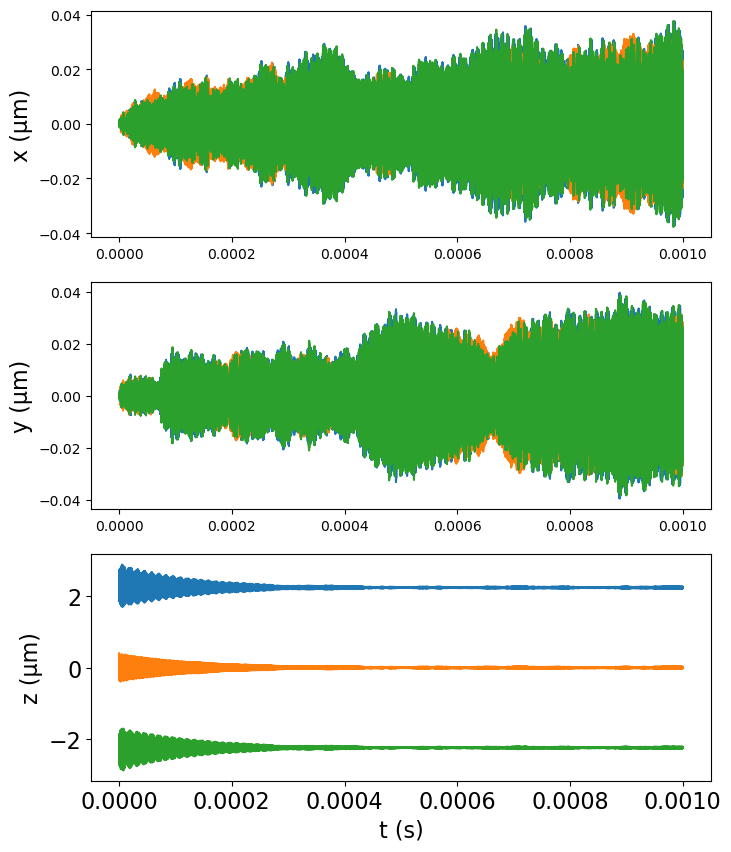

In [81]:
# Plot simulated ion trajectories
dim = 2
fig, ax = plt.subplots(3, figsize=(8, 10))
for k in range(n):
    # plt.plot(np.linspace(0, T, int(T / dt)+1), r_sim[:,k,dim])
    # plt.plot(t_sim, r_sim[:,k,dim])
    # plt.plot(t_sim, err_sim[:,k,dim])
    ax[0].plot(t_sim, r_sim[:,k,0] / 1e-6)
    ax[0].set_ylabel("x (µm)", fontsize=16)
    ax[1].plot(t_sim, r_sim[:,k,1] / 1e-6)
    ax[1].set_ylabel("y (µm)", fontsize=16)
    ax[2].plot(t_sim, r_sim[:,k,2] / 1e-6)
    ax[2].set_ylabel("z (µm)", fontsize=16)
    ax[2].tick_params(axis="x", labelsize=16)
    ax[2].tick_params(axis="y", labelsize=16)
# plt.plot(np.linspace(0,T,int(T / dt)+1), r_sim[:,0,2])
# plt.ylabel(f"r_{dim}")
plt.xlabel("t (s)", fontsize=16)
# plt.xlim(0, 1e-3)
# plt.ylim(-2e-5, 2e-5)
plt.show()

In [ ]:
# check if velocity agrees with doppler cooling limit
kB = 1.380649e-23
v_mag = np.linalg.norm(v_sim[60000:,0,:], axis=1)
K_rms = 0.5 * M_Yb * np.average(v_mag ** 2)
temp = (2/3) *(1/kB) * (K_rms)
doppler_temp = (hbar * transition_linewidth) / (2*kB)
print(f"Temperature: {temp} K")
print(f"Doppler Temperature: {doppler_temp} K")

In [ ]:
# calculate total energy at each step of simulation
def calc_tot_energy(r, v):
    return pot_energy(r.flatten()) + 0.5 * M_Yb * np.sum(v * v)

total_energy = np.array([calc_tot_energy(r_sim[i], v_sim[i]) for i in range(len(t_sim))])

In [ ]:
plt.plot(t_sim, total_energy)
plt.xlabel("t (s)")
plt.ylabel("Total Energy (J)")
plt.show()

In [ ]:
# Fourier Transform
from scipy.fft import rfft, rfftfreq, rfftn

yf = np.abs(rfftn(r_sim[:,1,1]))
xf = rfftfreq(int(T / dt), T/int(T/dt))

plt.plot(xf, yf)
plt.xlim((1e-9, 1e7))
# plt.ylim((0, 0.0012))
plt.show()

# Ring Trap Simulation

In [27]:
# physical constants
Z = 1   
e = 1.60217883e-19
eps0 = 8.854187817e-12
M_Yb = 2.8733965e-25
hbar = 1.05457182e-34

# trap parameters
n = 10 # number of ions
# trap_radius = 1e-3 # m, trap radius
trap_radius = (40 * 1e-6) / (2*np.pi) # m, trap radius
ion_electrode_distance = 1e-5 # <-- too small for actual trap ~200 µm is typical
s_cc = 2*np.sqrt(ion_electrode_distance * (2*trap_radius - ion_electrode_distance))
wr = 9 * 2*np.pi*1e6 # 1
wz = 10 * 2*np.pi*1e6 # 1.1

# laser cooling
laser_wavelength = 369 * 1e-9
k = (2*np.pi) / laser_wavelength
laser_origin = np.array([trap_radius, 0, 0])
kvector = k * np.array([0, 1, 0])

transition_linewidth = 19.6 * 1e6 * 2*np.pi
detuning = -transition_linewidth / 2
max_s = 1

n_lasers = 2
laser_origins = np.array([laser_origin, laser_origin])
laser_ks = np.array([k, k])
laser_detunings = np.array([detuning, detuning])
laser_kvectors = np.array([kvector, -kvector])

# n_lasers = 1
# laser_origins = np.array([laser_origin])
# laser_ks = np.array([k])
# laser_detunings = np.array([detuning])
# laser_kvectors = np.array([kvector])

laser_width = 2e-6

# functions to get a and q trap parameters

def cartesian_to_polar(cart):
    pol = np.zeros(cart.shape)
    if cart.ndim == 1:
        pol[0] = np.sqrt(cart[0]**2 + cart[1]**2)
        pol[1] = np.arctan2(cart[1], cart[0])
        if pol[1] < 0:
            pol[1] = 2*np.pi + pol[1]
        pol[2] = cart[2]
    else:
        pol[:,:,0] = np.sqrt(cart[:,:,0]**2 + cart[:,:,1]**2)
        pol[:,:,1] = np.arctan2(cart[:,:,1], cart[:,:,0])
        pol[:,:,1] = np.where(pol[:,:,1] < 0, 2*np.pi + pol[:,:,1], pol[:,:,1])
        pol[:,:,2] = cart[:,:,2]
    return pol

def polar_to_cartesian(pol):
    cart = np.zeros(pol.shape)
    if pol.ndim == 1:
        cart[0] = pol[0] * np.cos(pol[1])
        cart[1] = pol[0] * np.sin(pol[1])
        cart[2] = pol[2]
    else:
        cart[:,:,0] = pol[:,:,0] * np.cos(pol[:,:,1])
        cart[:,:,1] = pol[:,:,0] * np.sin(pol[:,:,1])
        cart[:,:,2] = pol[:,:,2]
    return cart

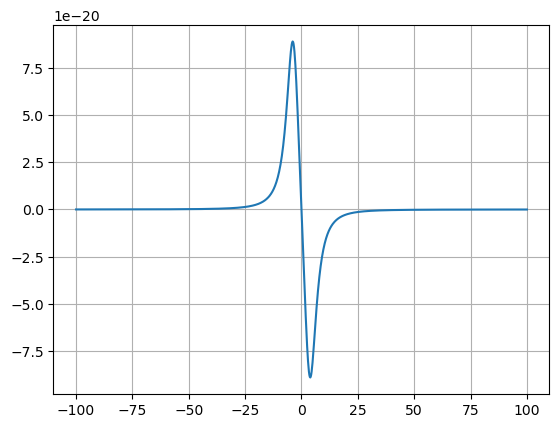

In [333]:
# messing w/ lorentzians
nvs = 1000
v_mag = np.linspace(-100, 100, nvs)
theta = (0) * np.pi
v = np.array([v_mag * np.sin(theta),
              v_mag * np.cos(theta),
              np.zeros(nvs)]).T
sat_param = 1
# scattering_rate = np.zeros(nvs)
laser_force = np.zeros((nvs, 3))
for i in range(n_lasers):
    laser_force += hbar * laser_kvectors[i] * ((transition_linewidth / 2) ** 3) * (1 / ( (laser_detunings[i] - laser_kvectors[i]*v)**2 + (transition_linewidth/2)**2 ))
    # scattering_rate += sat_param * transition_linewidth * ( 1 / ( 1 + 2*sat_param + ( (2*(laser_detunings[i] - np.dot(laser_kvectors[i], v)) / transition_linewidth ) ** 2 )))
plt.plot(v_mag, laser_force[:,1])
plt.grid()
plt.show()

In [3]:
# check trap frequencies with mathieu equation stability parameters
U = 1
V = 1
R = 1

def a(R, k, qm, Omega, U):
    return (4*qm*U) / ((R**2) * (Omega**2))

def q(R, k, qm, Omega, V):
    return (2*qm*V) / ((R**2) * (Omega**2))

R = trap_radius / 100   # ion-electrode distance
k = 1                   # geometric fudge factor
qm = (Z*e) / M_Yb       # ion charge-to-mass ratio
Omega = 30 * 1e6        # RF Frequency
U = 10                  # DC Potential (could use ion-ion spacing)
V = 100                 # RF Potential

print(f"a: {a(R, k, qm, Omega, U)}, q: {q(R, k, qm, Omega, V)}")

# outputs: secular frequency (in three directions), angles of secular motion, a (x,y,z), q (x,y,z)

a: 247.81803694686752, q: 1239.0901847343378


In [28]:
# energy and acceleration functions
# r_stray = np.array([])
charge_stray = np.array([e])
r_stray = np.array([[-trap_radius, 0, -1e-5]])
n_stray_charges = r_stray.shape[0]

def dist_to_laser(r, laser_origin, laser_kvector):
    return np.linalg.norm(np.cross(r-laser_origin, laser_kvector)) / np.linalg.norm(laser_kvector)

# velocity kick from laser
def lasers_kick(r, v, dt, laser_type="uniform"): # take individual ion position and velocity in
    total_kick = 0
    for i in range(n_lasers):
        if laser_type == "uniform":
            sat_param = 1
        elif laser_type == "gaussian":
            sat_param = max_s * np.exp( -2 * (dist_to_laser(r, laser_origins[i], laser_kvectors[i]) ** 2) / (laser_width ** 2) )
        scattering_rate = sat_param * transition_linewidth * ( 1 / ( 1 + 2*sat_param + ( (2*(laser_detunings[i] - np.dot(laser_kvectors[i], v)) / transition_linewidth ) ** 2 )))
        mean_scattered = scattering_rate * dt
        num_scattered = int(np.random.poisson(lam=mean_scattered))
        if num_scattered > 0:
            # absorption kick
            total_kick += (hbar * num_scattered * laser_kvectors[i]) / M_Yb

            # scattering kick
            directions = np.random.normal(size=(num_scattered, 3))
            norms = np.linalg.norm(directions, axis=1)
            norms = np.array([norms, norms, norms]).T
            directions = directions / norms
            total_kick += (hbar * laser_ks[i] / M_Yb) * (directions.sum(axis=0))

            # for j in range(num_scattered):
            #     direction = 2*np.random.rand(3) - 1
            #     total_kick += (hbar * laser_ks[i] / M_Yb) * (direction / np.linalg.norm(direction)) # scattering kick
    return total_kick

# calculate total potential energy
def pot_energy(r):
    n = r.size // 3
    energy = 0

    # harmonic potential
    for i in range(n):
        r_coord = np.sqrt(r[3*i]**2 + r[3*i+1]**2)
        energy += 0.5 * M_Yb * ((wr**2)*( (r_coord-trap_radius)**2 ) + (wz**2)*(r[3*i+2]**2))

    # couloumb potential
    for i in range(n):
        for j in range(i+1,n):
            dist = np.sqrt((r[3*i] - r[3*j])**2 + (r[3*i+1] - r[3*j+1])**2 + (r[3*i+2] - r[3*j+2])**2)
            energy += ((Z * Z * e * e) / (4 * np.pi * eps0)) * (1 / dist)

    return energy

# calculate gradient of potential energy
def jac(r):
    n = r.size // 3
    grad = np.zeros(n*3)

    # harmonic terms
    for i in range(n):
        r_coord = np.sqrt(r[3*i]**2 + r[3*i+1]**2)
        grad[3*i] = M_Yb * (wr**2) * (r_coord - trap_radius) * (r[3*i] / r_coord)
        grad[3*i+1] = M_Yb * (wr**2) * (r_coord - trap_radius) * (r[3*i+1] / r_coord)
        grad[3*i+2] = M_Yb * (wz**2) * r[3*i+2]

    # coulomb terms
    for i in range(n):
        for j in range(i+1, n):
            dist = np.sqrt((r[3*i] - r[3*j])**2 + (r[3*i+1] - r[3*j+1])**2 + (r[3*i+2] - r[3*j+2])**2)
            coulomb = ((Z * Z * e * e) / (4*np.pi*eps0)) * (1 / (dist ** 2))

            fx = coulomb * ((r[3*i] - r[3*j]) / dist)
            grad[3*i] -= fx; grad[3*j] += fx

            fy = coulomb * ((r[3*i+1] - r[3*j+1]) / dist)
            grad[3*i+1] -= fy; grad[3*j+1] += fy
            
            fz = coulomb * ((r[3*i+2] - r[3*j+2]) / dist)
            grad[3*i+2] -= fz; grad[3*j+2] += fz
    
    return grad

def acceleration(r, k, v=None, laser_type="none", coulomb_cutoff=0):
    # trap forces
    r_coord = np.sqrt(r[k][0]**2 + r[k][1]**2)
    a = np.array([-(wr**2) * (r_coord-trap_radius) * (r[k][0]/r_coord),
                  -(wr**2) * (r_coord-trap_radius) * (r[k][1]/r_coord),
                  -(wz**2) * r[k][2]])
    
    # laser cooling forces
    # if laser_type == "gaussian":
    #     sat_param = max_s * np.exp(-2 * (dist_to_laser(r[k]) ** 2) / (laser_width ** 2))
    #     scattering_rate = (decay_rate * sat_param) / (1 + 2*sat_param + (( (2*(detuning - np.dot(kvector, v[k])) / decay_rate )) ** 2))
    #     a += kvector * (hbar * scattering_rate) / M_Yb

    # coulomb forces
    for i in range(len(r)):
        if k != i:
            if coulomb_cutoff == 0 or np.linalg.norm(r[k]-r[i]) <= s_cc:
                coulomb_a = (((Z * Z * e * e) / (4*np.pi*eps0)) * (1 / (np.linalg.norm(r[k]-r[i]) ** 2))) / M_Yb
                dr = (r[k]-r[i]) / np.linalg.norm(r[k]-r[i])
                a += coulomb_a * dr
    return a

# perturbed potential
def perturbed_pot_energy(r):
    energy = pot_energy(r)
    for i in range(n_stray_charges):
        for j in range(n):
            dist = np.sqrt( (r_stray[i][0] - r[3*j])**2 + (r_stray[i][1] - r[3*j+1])**2 + (r_stray[i][2] - r[3*j+2])**2 )
            energy += ((charge_stray[i] * Z*e) / (4 * np.pi * eps0)) * (1 / dist)
    return energy

def perturbed_jac(r):
    n = r.size // 3
    grad = jac(r)

    for i in range(n_stray_charges):
        for j in range(n):
            dist = np.sqrt( (r_stray[i][0] - r[3*j])**2 + (r_stray[i][1] - r[3*j+1])**2 + (r_stray[i][2] - r[3*j+2])**2 )
            coulomb = ((charge_stray[i] * Z*e) / (4 * np.pi * eps0)) * (1 / (dist ** 2))

            fx = coulomb * ((r_stray[i][0] - r[3*j]) / dist)
            grad[3*j] += fx

            fy = coulomb * ((r_stray[i][1] - r[3*j+1]) / dist)
            grad[3*j+1] += fy

            fz = coulomb * ((r_stray[i][2] - r[3*j+2]) / dist)
            grad[3*j+2] += fz

    return grad

def perturbed_acceleration(r, k):
    a = acceleration(r, k)
    for i in range(n_stray_charges):
        coulomb_a = (((charge_stray[i] * Z*e) / (4*np.pi*eps0)) * (1 / (np.linalg.norm(r[k]-r_stray[i]) ** 2))) / M_Yb
        dr = (r[k] - r_stray[i]) / np.linalg.norm(r[k] - r_stray[i])
        a += coulomb_a * dr
    return a   

def acceleration_polar(r, v, k):
    n = len(r)
    a = np.zeros(3)
    dist2 = np.zeros(n)
    for i in range(n):
        dist2[i] = (r[k][0]*np.cos(r[k][1]) - r[i][0]*np.cos(r[i][1])) ** 2 + (r[k][0]*np.sin(r[k][1]) - r[i][0]*np.sin(r[i][1])) ** 2 + (r[k][2] - r[i][2]) ** 2

    a[0] = r[k][0]*(v[k][1]**2) - (wr*wr)*(r[k][0]-trap_radius) # r-component
    a[1] = -(2*v[k][0]*v[k][1])/r[k][0]
    a[2] = -(wz*wz)*r[k][2]
    kqq = (Z*Z*e*e) / (4*np.pi*eps0)
    for i in range(n):
        if i != k:
            a[0] += (kqq / M_Yb) * ((r[k][0] - r[i][0]*np.cos(r[k][1]-r[i][1])) / (dist2[k][i] ** (3/2)))
            a[1] += (kqq / (M_Yb*r[k][0]*r[k][0])) * ((r[k][0]*r[i][0]*np.sin(r[k][1]-r[i][1])) / (dist2[k][i] ** (3/2)))
            a[2] += (kqq / M_Yb) * ((r[k][2] - r[i][2]) / (dist2[k][i] ** (3/2)))
    
    return a

In [490]:
# plot points on sphere to check randomness of distribition

directions = np.random.normal(0, 1, size=(1000, 3))
# directions = 2*np.random.rand(1000, 3) - 1
norms = np.linalg.norm(directions, axis=1)
norms = np.array([norms, norms, norms]).T
directions = directions / norms
print(directions.sum(axis=0))

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter(directions[:,0], directions[:,1], directions[:,2])
# plt.show()

[ 2.79082287 -4.5683718  10.60692973]


In [29]:
# find equilibrium positions
import scipy.optimize as optimize

def get_ring_eq_pos(n, offset=0, perturbed=False, coord_system="cart"):
    r_0 = np.zeros((n, 3))
    for i in range(n):
        r_0[i][0] = trap_radius
        r_0[i][1] = (i / n) * 2*np.pi + offset
        r_0[i][2] = 0
        r_0[i] = polar_to_cartesian(r_0[i])
    
    bfgs_tolerance = 1e-34
    opt = optimize.minimize((perturbed_pot_energy if perturbed else pot_energy), 
                             r_0.flatten(), 
                             method="BFGS", 
                             jac=(perturbed_jac if perturbed else jac),
                             options={"gtol": bfgs_tolerance, "disp": False})
    
    r_eq = opt.x.reshape((n, 3))
    if coord_system == "pol":
        r_eq = cartesian_to_polar(r)
    return r_eq

In [111]:
# calculate equilibrium positions
r_eq = get_ring_eq_pos(n, offset=0, perturbed=False)

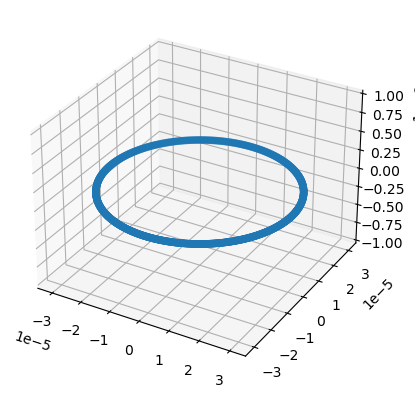

In [117]:
# plot equilibrium positions
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(r_eq[:,0], r_eq[:,1], r_eq[:,2])
# plt.plot(r_eq[:,0], r_eq[:,1], marker=".", linestyle="")
# r_eq = get_ring_eq_pos(n, offset=0, perturbed=True)
# plt.plot(r_eq[:,0], r_eq[:,1], marker="o", linestyle="")
# plt.xlim(-1.5*trap_radius, 1.5*trap_radius)
# plt.ylim(-1.5*trap_radius, 1.5*trap_radius)
# plt.xlabel("x (m)")
# plt.ylabel("y (m)")
# ax.set_xlim(-1e-6, 1e-6)
ax.set_zlim(-1e-8, 1e-8)
plt.show()

In [82]:
# calculate equilibrium radius vs. ion number
npts = 20
ns = np.linspace(1, 200, npts)
radii = np.zeros(npts)
for i in range(npts):
    r_eq = get_ring_eq_pos(int(ns[i]))
    radii[i] = r_eq[0][0]

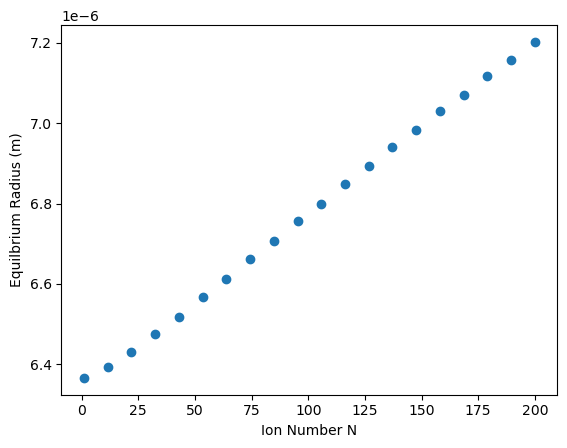

In [86]:
# plot equilibrium radius vs. ion number
plt.plot(ns, radii, marker="o", linestyle="")
plt.xlabel("Ion Number N")
plt.ylabel("Equilbrium Radius (m)")
plt.show()

In [30]:
# get normal modes and corresponding frequencies
def get_ring_eigenmodes(n, coord_system="cart"):
    r_eq = get_ring_eq_pos(n, 0, coord_system="cart")
    x = r_eq[:,0]
    y = r_eq[:,1]
    z = r_eq[:,2]
    dist2 = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist2[i,j] = ((x[i] - x[j]) ** 2) + ((y[i] - y[j]) ** 2) + ((z[i] - z[j]) ** 2)

    A = np.zeros((3*n, 3*n))
    kqq = (Z*Z*e*e) / (4*np.pi*eps0)
    for i in range(n):
        for j in range(n):
            if i == j:
                A[3*i][3*i] += M_Yb * (wr ** 2) * (1 - (trap_radius * (y[i] ** 2)) / ((x[i] ** 2 + y[i] ** 2) ** (3/2)))
                A[3*i+1][3*i+1] += M_Yb * (wr ** 2) * (1 - (trap_radius * (x[i] ** 2)) / ((x[i] ** 2 + y[i] ** 2) ** (3/2)))
                A[3*i+2][3*i+2] += M_Yb * (wz ** 2)
                A[3*i][3*i+1] += (M_Yb * (wr ** 2) * trap_radius * x[i] * y[i]) / ((x[i] ** 2 + y[i] ** 2) ** (3/2))
                A[3*i+1][3*i] += (M_Yb * (wr ** 2) * trap_radius * x[i] * y[i]) / ((x[i] ** 2 + y[i] ** 2) ** (3/2))
                for k in range(n):
                    if k != i:
                        A[3*i][3*i] -= kqq * ((dist2[i,k] - 3*((x[i] - x[k]) ** 2)) / (dist2[i,k] ** (5/2)))
                        A[3*i+1][3*i+1] -= kqq * ((dist2[i,k] - 3*((y[i] - y[k]) ** 2)) / (dist2[i,k] ** (5/2)))
                        A[3*i+2][3*i+2] -= kqq * ((dist2[i,k] - 3*((z[i] - z[k]) ** 2)) / (dist2[i,k] ** (5/2)))
                        A[3*i][3*i+1] += 3 * kqq * (((x[i]-x[k])*(y[i]-y[k])) / (dist2[i,k] ** (5/2)))
                        A[3*i+1][3*i] += 3 * kqq * (((x[i]-x[k])*(y[i]-y[k])) / (dist2[i,k] ** (5/2)))
                        A[3*i][3*i+2] += 3 * kqq * (((x[i]-x[k])*(z[i]-z[k])) / (dist2[i,k] ** (5/2)))
                        A[3*i+2][3*i] += 3 * kqq * (((x[i]-x[k])*(z[i]-z[k])) / (dist2[i,k] ** (5/2)))
                        A[3*i+1][3*i+2] += 3 * kqq * (((y[i]-y[k])*(z[i]-z[k])) / (dist2[i,k] ** (5/2)))
                        A[3*i+2][3*i+1] += 3 * kqq * (((y[i]-y[k])*(z[i]-z[k])) / (dist2[i,k] ** (5/2)))
            else:
                A[3*i][3*j] = kqq * ((dist2[i,j] - 3*((x[i]-x[j]) ** 2)) / (dist2[i,j] ** (5/2)))
                A[3*i+1][3*j+1] = kqq * ((dist2[i,j] - 3*((y[i]-y[j]) ** 2)) / (dist2[i,j] ** (5/2)))
                A[3*i+2][3*j+2] = kqq * ((dist2[i,j] - 3*((z[i]-z[j]) ** 2)) / (dist2[i,j] ** (5/2)))
                A[3*i][3*j+1] = -3 * kqq * ( ((x[i]-x[j])*(y[i]-y[j])) / (dist2[i,j] ** (5/2)) )
                A[3*i+1][3*j] = -3 * kqq * ( ((x[i]-x[j])*(y[i]-y[j])) / (dist2[i,j] ** (5/2)) )
                A[3*i][3*j+2] = -3 * kqq * ( ((x[i]-x[j])*(z[i]-z[j])) / (dist2[i,j] ** (5/2)) )
                A[3*i+2][3*j] = -3 * kqq * ( ((x[i]-x[j])*(z[i]-z[j])) / (dist2[i,j] ** (5/2)) )
                A[3*i+1][3*j+2] = -3 * kqq * ( ((y[i]-y[j])*(z[i]-z[j])) / (dist2[i,j] ** (5/2)) )
                A[3*i+2][3*j+1] = -3 * kqq * ( ((y[i]-y[j])*(z[i]-z[j])) / (dist2[i,j] ** (5/2)) )

    eigenvalues, eigenvectors = np.linalg.eigh(A)
    eigenvectors = eigenvectors.T.reshape((-1, n, 3))
    if coord_system == "pol":
        eigenvectors = cartesian_to_polar(eigenvectors)
    return eigenvalues, eigenvectors

In [50]:
# plot eigenmodes
# r_eq = get_ring_eq_pos(n, 0, coord_system="cart")
# efreqs, evecs = get_ring_eigenmodes(n, coord_system="cart")

# k = 0

# fig, ax = plt.subplots()

# ax.set_xlabel("x (mm)", fontsize=16)
# ax.set_ylabel("y (mm)", fontsize=16)
# ax.set_xlim(-2, 2)
# ax.set_ylim(-2, 2)
# ax.set_yticks(np.array([-2, -1, 0, 1, 2]))
# ax.tick_params(axis="x", labelsize=16)
# ax.tick_params(axis="y", labelsize=16)
# for i in range(n):
#     ax.arrow(1e3 * r_eq[i][0], 1e3 * r_eq[i][1], 2 * evecs[k][i][0], 2 * evecs[k][i][1], width=0.03)

# ax.add_patch(plt.Circle((0,0), trap_radius * 1e3, fill=False, color="gray"))
# plt.show()

# fig, ax = plt.subplots(2, n // 2, figsize=(50, 20))
# for k in range(n):
#     # ax.flat[k].set_xlim(-1e-5, 1e-5)
#     # ax.flat[k].set_ylim(-1e-5, 1e-5)
#     # ax.flat[k].add_patch(plt.Circle((0,0), trap_radius, fill=False, color="gray"))
#     ax.flat[k].add_patch(plt.Circle((0,0), 1e6 * trap_radius, fill=False, color="gray"))
#     ax.flat[k].set_xlim(-10, 10)
#     ax.flat[k].set_ylim(-10, 10)
#     ax.flat[k].set_xlabel("x (µm)", fontsize=20)
#     ax.flat[k].set_ylabel("y (µm)", fontsize=20)
#     ax.flat[k].tick_params(axis="x", labelsize=20)
#     ax.flat[k].tick_params(axis="y", labelsize=20)
#     for i in range(n):
#         ax.flat[k].arrow(1e6 * r_eq[i][0], 1e6 * r_eq[i][1], 10 * evecs[k][i][0], 10 * evecs[k][i][1], width=0.1)
#         # ax.flat[k].arrow(r_eq[i][0], r_eq[i][1], 1e-5 * evecs[k][i][0], 1e-5 * evecs[k][i][1], width=1e-7)
# plt.show()

In [495]:
# check eigenmode orthogonality

evals, evecs = get_ring_eigenmodes(n, coord_system="cart")
# flat_evecs = evecs.reshape((3*n,3*n))
# # print(efreqs)
# # for i in range(3*n):
# #     for j in range(i+1,3*n):
# #         print(f"{i} {j} {np.dot(flat_evecs[i], flat_evecs[j])}")
print(evals)
print(np.sqrt(evals / M_Yb))
# np.sqrt((e*e) / (4*np.pi*eps0*M_Yb * (4e-6 ** 3)))

[-2.04023663e-25  9.18840890e-10  1.13437147e-09]
[              nan 56548667.76461627 62831853.07179586]


/Users/pranav/opt/miniconda3/envs/miscenv/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


In [31]:
# simulation algorithms

# leapfrog simulation
def sim_leapfrog(n, T, dt, r_0, v_0, lasers=False, perturbed=False):
    n_tsteps = int(T / dt)
    r = np.zeros((n_tsteps+1, n, 3))
    v = np.zeros((n_tsteps+1, n, 3))
    # vhalf = np.zeros((n_tsteps+1, n, 3))
    a = np.zeros((n_tsteps+1, n, 3))

    r[0] = r_0; v[0] = v_0
    for k in range(n):
        a[0,k] = perturbed_acceleration(r[0], k) if perturbed else acceleration(r[0], k, coulomb_cutoff=0)

    for i in range(n_tsteps):
        for k in range(n):
            # vhalf[i,k] = v[i,k] + 0.5*dt*a[i,k]
            r[i+1,k] = r[i,k] + dt*v[i,k] + 0.5*dt*dt*a[i,k]
        for k in range(n):
            a[i+1,k] = perturbed_acceleration(r[i+1], k) if perturbed else acceleration(r[i+1], k, coulomb_cutoff=0)
            v[i+1,k] = v[i,k] + 0.5*dt*(a[i,k] + a[i+1,k])
            if lasers:
                v[i+1,k] += lasers_kick(r[i,k]+0.5*dt*v[i,k]+0.125*dt*dt*a[i,k], v[i,k]+0.5*dt*a[i,k], dt, laser_type="gaussian")
    
    return r, v, a

# euler-richardson simulation
def sim_er(n, n_tsteps, dt, etol, r_0, v_0):
    r = np.zeros((n_tsteps+1, n, 3))
    v = np.zeros((n_tsteps+1, n, 3))
    a = np.zeros((n_tsteps+1, n, 3))
    t = np.zeros((n_tsteps+1))
    err = np.zeros((n_tsteps+1, n, 3))

    r[0] = r_0; v[0] = v_0
    for k in range(n):
        a[0,k] = acceleration_polar(r[0], v[0], k)
        # a[0,k] = acceleration(r[0], k, v=v[0], laser_type="none")

    for i in range(n_tsteps):
        rhalf = np.zeros((n, 3))
        vhalf = np.zeros((n, 3))
        for k in range(n):
            rhalf[k] = r[i,k] + v[i,k]*(dt/2)
            vhalf[k] = v[i,k] + a[i,k]*(dt/2)
        for k in range(n):  
            ahalf = acceleration_polar(rhalf, vhalf, k)
            # ahalf = acceleration(rhalf, k, v=vhalf, laser_type="none")
            r[i+1,k] = r[i,k] + vhalf[k]*dt
            v[i+1,k] = v[i,k] + ahalf*dt
            rerr = np.abs( ( (v[i,k] - vhalf[k])*dt ) / 2) # 1 is the order of magnitude of r
            verr = np.abs( ( (a[i,k] - ahalf)*dt ) / 2)
            err[i,k] = max(max(rerr), max(verr))
        for k in range(n):
            a[i+1,k] = acceleration_polar(r[i+1], v[i+1], k)
            # a[i+1,k] = acceleration(r[i+1], k, v=v[i+1], laser_type="none")

        t[i+1] = t[i] + dt
        # dt = 0.9 * np.sqrt(etol / np.max(err[i])) * dt

    return r, v, a, t, err

In [32]:
# simulation function (md_sim)
from src import ion_trap_ring

def md_sim(n, r_0, v_0, implementation="python", algorithm="leapfrog", alg_args={}, lasers=False, perturbed=False):
    if implementation == "python":
        r_0 = r_0. reshape((n, 3))
        v_0 = v_0.reshape((n, 3))
        if algorithm == "leapfrog":
            r_sim, v_sim, a_sim = sim_leapfrog(n, alg_args["T"], alg_args["dt"], r_0, v_0, lasers=lasers, perturbed=perturbed)
            t_sim = np.linspace(0, alg_args["T"], int(alg_args["T"]/alg_args["dt"])+1)
        elif algorithm == "er":
            r_sim, v_sim, a_sim, t_sim, err_sim = sim_er(n, alg_args["n_tsteps"], alg_args["dt"], alg_args["etol"], r_0, v_0)
        return r_sim, v_sim, a_sim, t_sim
    
    elif implementation == "c++":
        r_0 = r_0.reshape(3*n)
        v_0 = v_0.reshape(3*n)
        if algorithm == "leapfrog":
            r_sim, v_sim, a_sim = ion_trap_ring.sim_leapfrog(n, alg_args["T"], alg_args["dt"], r_0, v_0)
            t_sim = np.linspace(0, alg_args["T"], int(alg_args["T"]/alg_args["dt"])+1)
        
        r_sim = np.array(r_sim).reshape((-1, n, 3))
        v_sim = np.array(v_sim).reshape((-1, n, 3))
        a_sim = np.array(a_sim).reshape((-1, n, 3))
        t_sim = np.array(t_sim)

        return r_sim, v_sim, a_sim, t_sim

In [38]:
# starting positions and velocities
r_eq = get_ring_eq_pos(n, 0, coord_system="cart")
evals, evecs = get_ring_eigenmodes(n, coord_system="cart")
# efreqs = np.sqrt(evals / M_Yb)
# print(evals)
# print(efreqs / (2 * np.pi))
# print(cartesian_to_polar(evecs))
# print(evecs)

# excite jth eigenmode
j = 17
# print(efreqs[j] / (2 * np.pi))
r_0 = np.zeros((n, 3))
for i in range(n):
    r_0[i] = r_eq[i] # + evecs[j][i] * 3e-6

# generate noisy starting positions around equlibrium
# r_eq = get_ring_eq_pos(n,0,coord_system="cart")
# r_0 = np.copy(r_eq).reshape(3*n) + np.random.normal(loc=5e-9, scale=5e-9, size=r_eq.size)
# baseline_energy = pot_energy(r_eq.reshape(3*n))
# print(f"Baseline Energy: {baseline_energy}")
# print(f"Potential Energy: {pot_energy(r_0)}")
# print(f"Energy Difference: {baseline_energy - pot_energy(r_0)}")
# print(f"1.5•k_b•T: {1.5 * 1.380649e-23 * 0.01}") # 3/2 * k_b * T

v_0 = np.zeros((n, 3))
for i in range(n):
    v_0[i][0] = 100 # 1000000 # 62831
    v_0[i][1] = (i / n) * 2*np.pi + (np.pi / 2)
    v_0[i][2] = 0
    v_0[i] = polar_to_cartesian(v_0[i])

In [42]:
# run simulation

T = 1e-5
dt = 1e-8
# dt = 5e-10 # for fourier

r_sim, v_sim, a_sim, t_sim = md_sim(n, r_0, v_0, 
                                    implementation="c++", 
                                    algorithm="leapfrog", 
                                    alg_args={"T": T, "dt": dt},
                                    lasers=False,
                                    perturbed=False)

In [43]:
r_sim = cartesian_to_polar(r_sim)
# r_sim = polar_to_cartesian(r_sim)

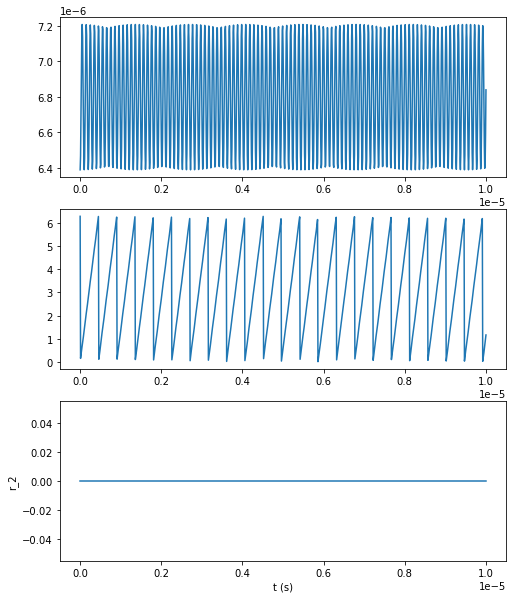

In [44]:
# plot trajectory vs time
dim = 2
fig, ax = plt.subplots(3, figsize=(8, 10))
for k in range(1):
    # plt.plot(np.linspace(0, T, int(T / dt)+1), r_sim[:,k,dim])
    # plt.plot(t_sim, r_sim[:,k,dim])
    # plt.plot(t_sim, err_sim[:,k,dim])
    ax[0].plot(t_sim, r_sim[:,k,0])
    # ax[0].set_ylim((6.3e-6, 6.4e-6))
    ax[1].plot(t_sim, r_sim[:,k,1])
    ax[2].plot(t_sim, r_sim[:,k,2])
# plt.plot(np.linspace(0,T,int(T / dt)+1), r_sim[:,0,2])
plt.ylabel(f"r_{dim}")
plt.xlabel("t (s)")
# plt.ylim(-2e-5, 2e-5)
# ax[2].set_xlim(0, 1e-4)
plt.show()

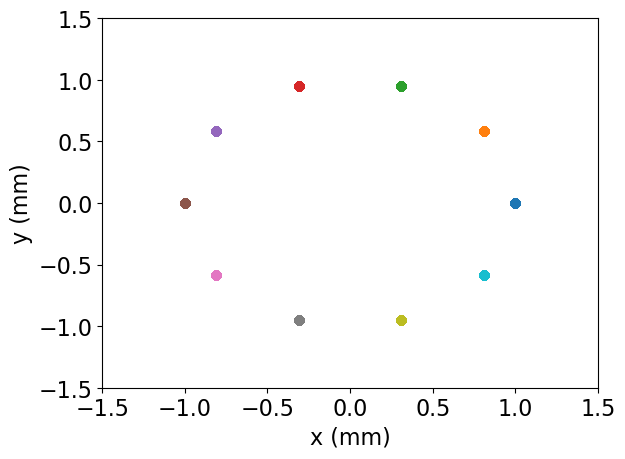

In [59]:
# plot spacial trajectory in plane of trap
for k in range(n):
    x = r_sim[:,k,0] / trap_radius
    y = r_sim[:,k,1] / trap_radius
    plt.plot(x, y, marker='o')
# plt.xlim(-0.00115, -0.0007)
# plt.xlim(-1.5*trap_radius, 1.5*trap_radius)
# plt.ylim(-1.5*trap_radius, 1.5*trap_radius)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("x (mm)", fontsize=16)
plt.ylabel("y (mm)", fontsize=16)
plt.show()

In [ ]:
# check if radius increases based on initial angular velocity of rotating mode
T = 5e-3
dt = 1e-8
for v in range(10, 101, 10):
    r_0 = get_ring_eq_pos(n, 0, coord_system="cart")
    v_0 = np.zeros((n, 3))
    for i in range(n):
        v_0[i][0] = v
        v_0[i][1] = (i / n) * 2*np.pi + (np.pi / 2)
        v_0[i][2] = 0
        v_0[i] = polar_to_cartesian(v_0[i])

    r_sim, v_sim, a_sim, t_sim = sim_cython(n, r_0, v_0, algorithm="leapfrog", args={"T": T, "dt": dt})
    radius = np.sqrt(r_sim[:,0,0]**2 + r_sim[:,0,1]**2)
    print(np.average(radius))
    
# conv = np.ones(int(1e-2 / 1e-6))
# avg = np.convolve(radius, conv, mode="valid") / conv.size
# plt.plot(np.arange(avg.size), avg)
# plt.plot(t_sim, radius)
# plt.xlim(0, 1e-5)
# plt.show()

In [ ]:
# animate trajectory in 3D
%matplotlib notebook
from matplotlib.animation import FuncAnimation

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
line, = ax.plot([], [], [], marker='o', linestyle="")

ax.set(xlim3d=(-0.0015, 0.0015), xlabel='X')
ax.set(ylim3d=(-0.0015, 0.0015), xlabel='Y')
ax.set(zlim3d=(-0.0015, 0.0015), xlabel='Z')

def init():
    line.set_data(r_sim[0,:,:2].T)
    line.set_3d_properties(r_sim[0,:,2])
    return line,

def animate(i):
    line.set_data(r_sim[i,:,:2].T)
    line.set_3d_properties(r_sim[i,:,2])
    return line,

anim = FuncAnimation(fig, animate, init_func=init, frames=len(t_sim), interval=30, blit=True)
plt.show()

In [94]:
# calculate integration errors
r_ref, v_ref, a_ref, t_ref = md_sim(n, r_0, v_0, implementation="c++", algorithm="leapfrog", alg_args={"T": 1e-5, "dt": 2e-11})
r_ref_final = r_ref[-1,:,:].flatten()

nts = 80
dts = np.logspace(-10, -7.7, nts)
errs = np.zeros(nts)
for i in range(nts):
    r_sim, v_sim, a_sim, t_sim = md_sim(n, r_0, v_0, implementation="c++", algorithm="leapfrog", alg_args={"T": 1e-5, "dt": dts[i]})
    r_sim_final = r_sim[-1,:,:].flatten()
    errs[i] = np.sqrt( (1/n) * np.sum((r_sim_final - r_ref_final) ** 2))

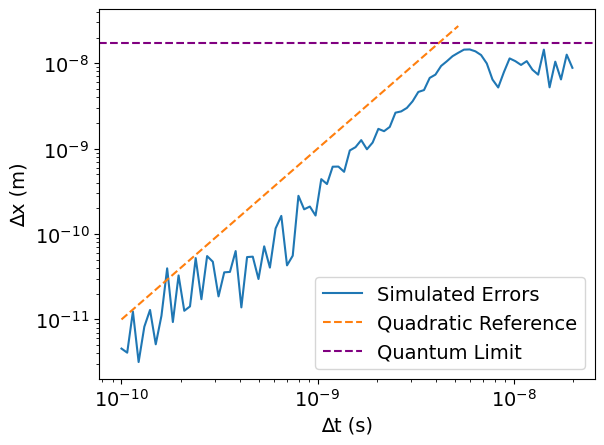

In [95]:
# plot integration errors
plt.loglog(dts, errs, label="Simulated Errors")
plt.loglog(dts[:60], 1e9*(dts[:60]**2), linestyle="dashed", label="Quadratic Reference")
plt.axhline(np.sqrt(hbar / (2*M_Yb * 1e5 * 2*np.pi)), linestyle="dashed", color="purple", label="Quantum Limit")
plt.xlabel("∆t (s)", fontsize=14)
plt.ylabel("∆x (m)", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [26]:
w = 1e5 * 2*np.pi
np.sqrt(hbar / (2*M_Yb * w))

1.7089736627636854e-08

In [ ]:
# Fourier Transform
from scipy.fft import rfft, rfftfreq, rfftn

# yf = np.abs(rfftn(np.sin(np.unwrap(r_sim[:,0,0]))))
yf = np.abs(rfftn(r_sim[:,0,1]))
xf = rfftfreq(int(T / dt), T/int(T/dt))

plt.plot(xf, yf)
plt.xlim(9e6, 9.2e6)
plt.ylim((0, 5))
plt.show()

In [ ]:
# get peaks from fourier transform
from scipy.signal import argrelmax

maxi = argrelmax(yf)
maxres = yf[maxi]
maxfreq = xf[maxi]
# print(np.flip(np.sort(maxres))[:10])

resfreq = np.array([maxres, maxfreq]).T # dtype=[("freq", float), ("res", float)]
resfreq_sorted = np.flip(resfreq[resfreq[:,0].argsort()])
resfreq_sorted[:30]

In [ ]:
# iterate through modes and plot fourier transform

r_eq = get_ring_eq_pos(n, 0, coord_system="cart")
evals, evecs = get_ring_eigenmodes(n, coord_system="cart")

for j in range(n):
    # excite jth eigenmode
    r_0 = np.zeros((n, 3))
    for i in range(n):
        r_0[i] = r_eq[i] + evecs[j][i] * 5e-7
    v_0 = np.zeros((n, 3))

    # run simulation
    T = 1e-3
    dt = 1e-8
    r_sim, v_sim, a_sim, t_sim = sim_cython(n, r_0, v_0, algorithm="leapfrog", args={"T": T, "dt": dt})

    # fourier trasnform and plot
    yf = np.abs(rfftn(np.sin(np.unwrap(r_sim[:,2,0]))))
    xf = rfftfreq(int(T / dt), T/int(T/dt))
    plt.plot(xf, yf, label=j)

plt.legend()
plt.xlim(0, 2e6)
plt.ylim(0, 0.015)
plt.show()

In [ ]:
# np.argmax(yf[1:])
print(f"{xf[23]} {yf[23]}")

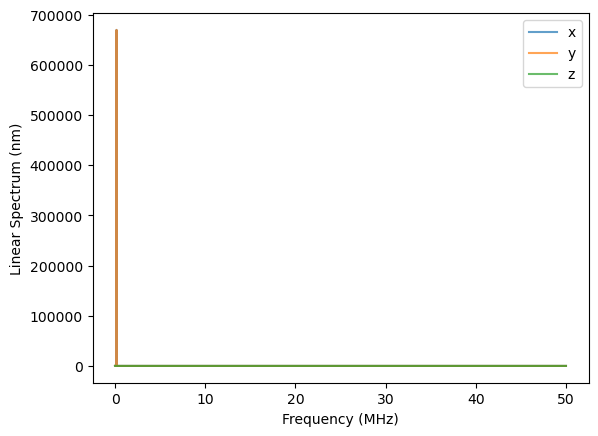

In [38]:
# FFT with windowing and linear spectral density
from scipy.signal import welch, butter, sosfilt

n_tsteps = int(T/dt)

# sos = butter(10, 1e5, fs=(1/dt), btype="highpass", output="sos")
# r_filt = sosfilt(sos, r_sim[:,0,0])
# plt.plot(np.linspace(0,T,n_tsteps+1), r_filt)

dims = {
        0: "x", 
        1: "y", 
        2: "z",
        }
for i in dims:
    freq, Pxx_spec = welch(r_sim[:,0,i], fs=(1/dt), window="hann", scaling="spectrum", nperseg=n_tsteps)
    lin_spec = Pxx_spec ** 0.5
    plt.plot(freq / 1e6, lin_spec * 1e9, label=dims[i], alpha=0.7)
# plt.plot(freq, lin_spec)
# plt.plot(freq[:20000], lin_spec[:20000])

# freq, Pxx_spec = we
# lch(r_sim[28000:29000,3,0], fs=(1/dt), window="hann", scaling="spectrum", nperseg=n_tsteps)
# lin_spec1 = Pxx_spec ** 0.5
# # plt.plot(freq, lin_spec1, alpha=0.2)

# freq, Pxx_spec = welch(r_sim[18000:19000,3,0], fs=(1/dt), window="hann", scaling="spectrum", nperseg=n_tsteps)
# lin_spec2 = Pxx_spec ** 0.5
# # plt.plot(freq, lin_spec2, alpha=0.2)

# freq, Pxx_spec = welch(r_sim[:1000,3,0], fs=(1/dt), window="hann", scaling="spectrum", nperseg=n_tsteps)
# lin_spec3 = Pxx_spec ** 0.5
# # plt.plot(freq, lin_spec3, alpha=0.2)


# plt.xlim(0, 1.2e7) # for all modes
# plt.xlim((0, 2e6)) # for azimuthal eigenmodes
# plt.xlim((0, 0.1)) # for azimuthal eigenmodes
# plt.ylim((0, 10000))
# plt.xlim((8.8e6, 9.2e6)) # for radial eigenmodes
# plt.ylim((0, 1e-11))
# plt.xlim(9.9e6, 1.0025e7) # for axial eigenmodes

plt.xlabel("Frequency (MHz)")
plt.ylabel("Linear Spectrum (nm)")
plt.legend()
plt.show()

In [ ]:
# get peaks from fourier transform with power spectral density
from scipy.signal import argrelmax

maxi = argrelmax(lin_spec)[0]
maxres = lin_spec[maxi]
maxfreq = freq[maxi]
# print(np.flip(np.sort(maxres))[:10])

resfreq = np.array([maxres, maxfreq]).T # dtype=[("freq", float), ("res", float)]
resfreq_sorted = np.flip(resfreq[resfreq[:,0].argsort()])
resfreq_sorted[:30]

In [ ]:
# check if energy moves between modes

maxes1 = np.zeros(n_tsteps // 1000)
maxes2 = np.zeros(n_tsteps // 1000)
for i in range(0, n_tsteps, 1000):
    freq, Pxx_spec = welch(r_sim[i:i+1000,3,0], fs=(1/dt), window="hann", scaling="spectrum", nperseg=1000)
    lin_spec = Pxx_spec ** 0.5
    # plt.plot(lin_spec[14:20])
    # plt.ylim((0, 2e-9))
    maxes1[i // 1000] = np.max(lin_spec)
    maxes2[i // 1000] = np.max(lin_spec[:50])

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(maxes1 - np.average(maxes1), alpha=0.7)
ax1.set_ylabel("Peak Amplitude 1")

ax2 = ax1.twinx()
ax2.plot(maxes2 - np.average(maxes2), color="red", alpha=0.3)
ax2.set_ylabel("Peak Amplitude 2")

# plt.xlim(0, 200)
plt.xlabel("Index")

plt.show()

In [28]:
# Calculate total energy at each timestep
import ion_trap_ring

def calc_tot_energy(r, v):
    return ion_trap_ring.pot_energy(r.flatten()) + 0.5 * M_Yb * np.sum(v * v)

total_energy = np.array([calc_tot_energy(r_sim[i], v_sim[i]) for i in range(len(t_sim))])
# total_energy = np.array(ion_trap_ring.total_energy(r_sim.reshape((-1,3*n)), v_sim.reshape((-1,3*n))))

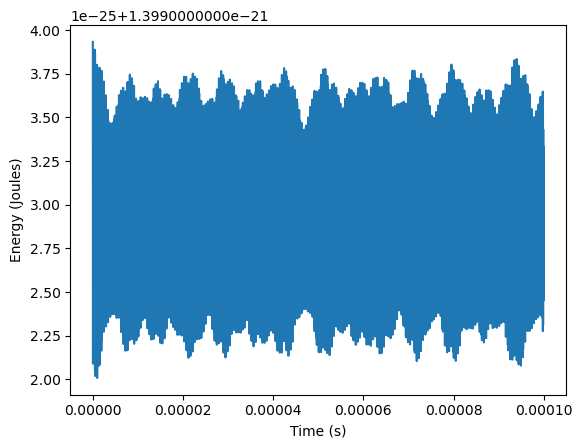

In [29]:
# plot total energy v. time
plt.plot(t_sim, total_energy)
# plt.xlim(0, 1e-5)
plt.xlabel("Time (s)")
plt.ylabel("Energy (Joules)")
plt.show()

# plot average total energy in 1000-timestep intervals
# avg_energy = np.zeros(n_tsteps // 1000)
# for i in range(0, n_tsteps, 1000):
#     avg_energy[i // 1000] = np.average(total_energy[i:i+1000])
# plt.plot(avg_energy)
# plt.xlabel("Index")
# plt.ylabel("Mean Energy")
# plt.show()

# Dimensionless Ringtrap Simulation

In [57]:
# physical constants
Z = 1   
e = 1.60217883e-19
eps0 = 8.854187817e-12
M_Yb = 2.8733965e-25
hbar = 1.05457182e-34

# trap parameters
n = 2 # number of ions
trap_radius = (40 * 1e-6) / (2*np.pi) # m, trap radius
# trap_radius = 1e-3 # m, trap radius
wr = 9 * 2*np.pi*1e6 # TODO: change to 1 and 1.1
wz = 10 * 2*np.pi*1e6

# dimensionless conversion factors
w_std = 10 * 2*np.pi*1e6
M0 = M_Yb
T0 = 1/w_std
R0 = ((Z*Z*e*e) / (4*np.pi*eps0 * M_Yb*w_std*w_std)) ** (1/3)

print(f"M0: {M0}")
print(f"T0: {T0}")
print(f"R0: {R0}")

M0: 2.8733965e-25
T0: 1.5915494309189534e-08
R0: 5.880794852186074e-07


In [58]:
# find equilibrium positions
def get_ring_eq_pos(n, offset, coord_system="cart"):
    r_eq = np.zeros((n, 3))
    for i in range(n):
        r_eq[i][0] = trap_radius * np.cos((i / n) * 2*np.pi + offset) * (1/R0)
        r_eq[i][1] = trap_radius * np.sin((i / n) * 2*np.pi + offset) * (1/R0)
        r_eq[i][2] = 0
    return r_eq

In [59]:
# get normal modes and corresponding frequencies
def get_ring_eigenmodes(n, coord_system="cart"):
    r_eq = get_ring_eq_pos(n, 0)
    x = r_eq[:,0]
    y = r_eq[:,1]
    z = r_eq[:,2]
    dist2 = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist2[i,j] = ((x[i] - x[j]) ** 2) + ((y[i] - y[j]) ** 2) + ((z[i] - z[j]) ** 2)

    A = np.zeros((3*n, 3*n))
    for i in range(n):
        for j in range(n):
            if i == j:
                A[3*i][3*i] += ((wr / w_std) ** 2) * (1 - ((trap_radius / R0) * (y[i] ** 2)) / ((x[i] ** 2 + y[i] ** 2) ** (3/2)))
                A[3*i+1][3*i+1] += ((wr / w_std) ** 2) * (1 - ((trap_radius / R0) * (x[i] ** 2)) / ((x[i] ** 2 + y[i] ** 2) ** (3/2)))
                A[3*i+2][3*i+2] += ((wz / w_std) ** 2)
                A[3*i][3*i+1] += (((wr / w_std) ** 2) * (trap_radius / R0) * x[i] * y[i]) / ((x[i] ** 2 + y[i] ** 2) ** (3/2))
                A[3*i+1][3*i] += (((wr / w_std) ** 2) * (trap_radius / R0) * x[i] * y[i]) / ((x[i] ** 2 + y[i] ** 2) ** (3/2))
                for k in range(n):
                    if k != i:
                        A[3*i][3*i] -= ((dist2[i,k] - 3*((x[i] - x[k]) ** 2)) / (dist2[i,k] ** (5/2)))
                        A[3*i+1][3*i+1] -= ((dist2[i,k] - 3*((y[i] - y[k]) ** 2)) / (dist2[i,k] ** (5/2)))
                        A[3*i+2][3*i+2] -= ((dist2[i,k] - 3*((z[i] - z[k]) ** 2)) / (dist2[i,k] ** (5/2)))
                        A[3*i][3*i+1] += 3 * (((x[i]-x[k])*(y[i]-y[k])) / (dist2[i,k] ** (5/2)))
                        A[3*i+1][3*i] += 3 * (((x[i]-x[k])*(y[i]-y[k])) / (dist2[i,k] ** (5/2)))
                        A[3*i][3*i+2] += 3 * (((x[i]-x[k])*(z[i]-z[k])) / (dist2[i,k] ** (5/2)))
                        A[3*i+2][3*i] += 3 * (((x[i]-x[k])*(z[i]-z[k])) / (dist2[i,k] ** (5/2)))
                        A[3*i+1][3*i+2] += 3 * (((y[i]-y[k])*(z[i]-z[k])) / (dist2[i,k] ** (5/2)))
                        A[3*i+2][3*i+1] += 3 * (((y[i]-y[k])*(z[i]-z[k])) / (dist2[i,k] ** (5/2)))
            else:
                A[3*i][3*j] = ((dist2[i,j] - 3*((x[i]-x[j]) ** 2)) / (dist2[i,j] ** (5/2)))
                A[3*i+1][3*j+1] = ((dist2[i,j] - 3*((y[i]-y[j]) ** 2)) / (dist2[i,j] ** (5/2)))
                A[3*i+2][3*j+2] = ((dist2[i,j] - 3*((z[i]-z[j]) ** 2)) / (dist2[i,j] ** (5/2)))
                A[3*i][3*j+1] = -3 * ( ((x[i]-x[j])*(y[i]-y[j])) / (dist2[i,j] ** (5/2)) )
                A[3*i+1][3*j] = -3 * ( ((x[i]-x[j])*(y[i]-y[j])) / (dist2[i,j] ** (5/2)) )
                A[3*i][3*j+2] = -3 * ( ((x[i]-x[j])*(z[i]-z[j])) / (dist2[i,j] ** (5/2)) )
                A[3*i+2][3*j] = -3 * ( ((x[i]-x[j])*(z[i]-z[j])) / (dist2[i,j] ** (5/2)) )
                A[3*i+1][3*j+2] = -3 * ( ((y[i]-y[j])*(z[i]-z[j])) / (dist2[i,j] ** (5/2)) )
                A[3*i+2][3*j+1] = -3 * ( ((y[i]-y[j])*(z[i]-z[j])) / (dist2[i,j] ** (5/2)) )

    eigenvalues, eigenvectors = np.linalg.eigh(A)
    eigenvectors = eigenvectors.T.reshape((-1, n, 3))
    if coord_system == "pol":
        eigenvectors = cartesian_to_polar(eigenvectors)
    return eigenvalues, eigenvectors

In [60]:
# plot eigenmodes
# r_eq = get_ring_eq_pos(n, 0, coord_system="cart")
# evals, evecs = get_ring_eigenmodes(n, coord_system="cart")

# fig, ax = plt.subplots(n, 2, figsize=(n, 2.5*n))
# for k in range(2*n):
#     # ax.flat[k].set_xlim(-1e-5, 1e-5)
#     # ax.flat[k].set_ylim(-1e-5, 1e-5)
#     # ax.flat[k].add_patch(plt.Circle((0,0), trap_radius, fill=False, color="gray"))
#     ax.flat[k].add_patch(plt.Circle((0,0), trap_radius / R0, fill=False, color="gray"))
#     # ax.flat[k].set_xlim(-10, 10)
#     # ax.flat[k].set_ylim(-10, 10)
#     # ax.flat[k].set_xlabel("x (µm)", fontsize=20)
#     # ax.flat[k].set_ylabel("y (µm)", fontsize=20)
#     # ax.flat[k].tick_params(axis="x", labelsize=20)
#     # ax.flat[k].tick_params(axis="y", labelsize=20)
#     for i in range(n):
#         ax.flat[k].arrow(r_eq[i][0], r_eq[i][1], (trap_radius / R0) * evecs[k][i][0], (trap_radius / R0) * evecs[k][i][1], width=(trap_radius / R0) / 100)
#         # ax.flat[k].arrow(r_eq[i][0], r_eq[i][1], 1e-5 * evecs[k][i][0], 1e-5 * evecs[k][i][1], width=1e-7)
# plt.show()

In [61]:
evals, evecs = get_ring_eigenmodes(n)
print(evals)
print(np.sqrt(evals))
# print(evecs)

[-1.97064197e-04  7.39222594e-17  8.10000000e-01  8.10394128e-01
  9.99802936e-01  1.00000000e+00]
[           nan 8.59780550e-09 9.00000000e-01 9.00218934e-01
 9.99901463e-01 1.00000000e+00]


/Users/pranav/opt/miniconda3/envs/miscenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
